<center><img src='../img/us_heart_disease_rates_2018_2020.jpg' alt='Heart Disease Rates 2018-2020' height='300'/></center>

# Indicators of Heart Disease (2022 dataset)

## Abstract

According to the [U.S. Center for Disease Control and Prevention](https://www.cdc.gov/) (CDC), heart disease is one of the [primary causes of death](https://www.cdc.gov/heart-disease/data-research/facts-stats/index.html) across racial groups in the United States. Nearly half of all Americans (47%) live with at least one of the top [three risk factors](https://www.cdc.gov/heart-disease/risk-factors/?CDC_AAref_Val=https://www.cdc.gov/heartdisease/risk_factors.htm): high blood pressure, high cholesterol, or smoking. Other significant risk indicators include diabetes, obesity (high BMI), insufficient physical activity, and excessive alcohol consumption. Reducing these risk factors is crucial in healthcare, as they heavily influence heart disease rates. With advances in computing, machine learning offers powerful tools to analyze and detect "patterns" in health data that may help predict and manage heart conditions.

## Dataset

The CDC [Behavioral Risk Factor Surveillance System](https://www.cdc.gov/brfss/annual_data/annual_2022.html) (BRFSS) plays a significant role. This system conducts yearly telephone surveys to gather health data from U.S. residents. According to the CDC: "Initiated in 1984 with just 15 states, BRFSS now gathers data from all 50 states, the District of Columbia, and three U.S. territories. Each year, BRFSS completes over 400,000 interviews with adults, making it the world’s largest ongoing health survey system." 

Within this dataset, it can be identified numerous factors (survey questions) that influence heart disease, either directly or indirectly. Therefore, the most relevant variables for analysis have been selected in a [condensed version of the original BRFSS dataset](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/data). 

## Goal

For a classification problem focused on detecting potential **heart attacks**, the choice of metric is critical. In such medical applications, it’s essential to **minimize the likelihood of missing true cases** (i.e., actual heart attacks) because a missed detection could have severe health implications. Therefore, **optimizing for recall** (also known as sensitivity or true positive rate) will be the priority. Recall measures the proportion of actual positive cases (heart attacks) that are correctly identified by the model. **By maximizing recall, we aim to reduce the chances of false negatives, which in this context means failing to identify a patient at risk.**

## Notes

Another important consideration is the balance between recall and precision, which is the proportion of predicted positive cases that are actually positive. High precision helps to avoid a high rate of false positives, which can lead to unnecessary treatments or additional tests. A metric that combines both recall and precision, such as the F1 score, could also be valuable, especially if false positives have significant, though lesser, consequences. The F1 score is the harmonic mean of precision and recall, making it particularly suitable when both false negatives and false positives carry costs.

In highly imbalanced medical datasets where heart attack cases are relatively rare, additional techniques such as ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) or Precision-Recall AUC can provide insight into the model’s performance across various decision thresholds. However, **recall should remain the primary focus because the medical importance of minimizing false negatives generally outweighs other factors**.

## References

https://www.cdc.gov/

https://www.cdc.gov/heart-disease/data-research/facts-stats/index.html

https://www.cdc.gov/heart-disease/risk-factors/?CDC_AAref_Val=https://www.cdc.gov/heartdisease/risk_factors.htm

https://www.cdc.gov/brfss/annual_data/annual_2022.html

https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/data


## Libraries


In [1]:
import os
import random
import sys
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (RFECV, SelectFromModel, SelectKBest,
                                       f_classif)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
from sklearn.svm import SVC
from sklearn.utils import shuffle
from xgboost import XGBClassifier

# add "src" path
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) 
if os.path.exists(root_path) and root_path not in sys.path: 
    sys.path.append(root_path)

from utils import vizdatatools as viz
from utils.datascience import get_cardinality

# modern style
sns.set_theme(style='darkgrid', palette='flare')

# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 

In [2]:
# numpy version==1.26.4 for compatibility with catboost
np.__version__

'1.26.4'

## Download dataset

In [3]:
# load dataset
df_heart = pd.read_csv('../data/raw/heart_disease_2022.csv')
df_heart.sample(5)

State     Sex GeneralHealth  PhysicalHealthDays  \
177421  Rhode Island  Female          Fair                30.0   
111841     Minnesota  Female     Excellent                 0.0   
206692       Vermont    Male          Good                 0.0   
233666     Wisconsin  Female     Very good                 0.0   
61917        Indiana  Female          Good                 0.0   

        MentalHealthDays  \
177421               5.0   
111841               5.0   
206692               0.0   
233666               0.0   
61917               15.0   

                                               LastCheckupTime  \
177421      Within past year (anytime less than 12 months ago)   
111841      Within past year (anytime less than 12 months ago)   
206692  Within past 2 years (1 year but less than 2 years ago)   
233666      Within past year (anytime less than 12 months ago)   
61917       Within past year (anytime less than 12 months ago)   

       PhysicalActivities  SleepHours  RemovedTeeth HadHeartAttack HadAngina  \
177421                 No         8.0  None of them            Yes        No   
111841                Yes         8.0  None of them             No        No   
206692                Yes         6.0  None of them             No        No   
233666                Yes         6.0        1 to 5             No        No   
61917                 Yes         6.0        1 to 5             No        No   

       HadStroke HadAsthma HadSkinCancer HadCOPD HadDepressiveDisorder  \
177421        No        No            No      No                   Yes   
111841        No        No            No      No                   Yes   
206692        No        No            No      No                    No   
233666        No        No            No      No                    No   
61917         No        No            No      No                    No   

       HadKidneyDisease HadArthritis HadDiabetes DeafOrHardOfHearing  \
177421               No          Yes         Yes                  No   
111841               No           No          No                  No   
206692               No           No          No                  No   
233666               No           No          No                  No   
61917                No           No          No                  No   

       BlindOrVisionDifficulty DifficultyConcentrating DifficultyWalking  \
177421                      No                      No                No   
111841                      No                      No                No   
206692                      No                      No                No   
233666                      No                      No                No   
61917                       No                      No                No   

       DifficultyDressingBathing DifficultyErrands  \
177421                        No                No   
111841                        No                No   
206692                        No                No   
233666                        No                No   
61917                         No                No   

                                 SmokerStatus  \
177421                          Former smoker   
111841                          Former smoker   
206692                           Never smoked   
233666  Current smoker - now smokes every day   
61917                            Never smoked   

                                  ECigaretteUsage ChestScan  \
177421  Never used e-cigarettes in my entire life       Yes   
111841                     Not at all (right now)        No   
206692  Never used e-cigarettes in my entire life        No   
233666  Never used e-cigarettes in my entire life       Yes   
61917   Never used e-cigarettes in my entire life        No   

            RaceEthnicityCategory   AgeCategory  HeightInMeters  \
177421   White only, Non-Hispanic  Age 70 to 74            1.52   
111841   White only, Non-Hispanic  Age 30 to 34            1.68   
206692   White only, Non-Hispanic  A

## Brief inspection

We are performing a quick inspection of the dataset before splitting it to gain a preliminary understanding of its structure, distributions, and any potential data quality issues.

In [4]:
# get basic information: size, cardinality, missing values
get_cardinality(df_heart)

pandas.DataFrame shape: (246022, 40)


Card    %_Card NaN_Values %_NaN_Values     Type  \
State                        54  0.021949          0          0.0   object   
Sex                           2  0.000813          0          0.0   object   
GeneralHealth                 5  0.002032          0          0.0   object   
PhysicalHealthDays           31    0.0126          0          0.0  float64   
MentalHealthDays             31    0.0126          0          0.0  float64   
LastCheckupTime               4  0.001626          0          0.0   object   
PhysicalActivities            2  0.000813          0          0.0   object   
SleepHours                   23  0.009349          0          0.0  float64   
RemovedTeeth                  4  0.001626          0          0.0   object   
HadHeartAttack                2  0.000813          0          0.0   object   
HadAngina                     2  0.000813          0          0.0   object   
HadStroke                     2  0.000813          0          0.0   object   
HadAsthma                     2  0.000813          0          0.0   object   
HadSkinCancer                 2  0.000813          0          0.0   object   
HadCOPD                       2  0.000813          0          0.0   object   
HadDepressiveDisorder         2  0.000813          0          0.0   object   
HadKidneyDisease              2  0.000813          0          0.0   object   
HadArthritis                  2  0.000813          0          0.0   object   
HadDiabetes                   4  0.001626          0          0.0   object   
DeafOrHardOfHearing           2  0.000813          0          0.0   object   
BlindOrVisionDifficulty       2  0.000813          0          0.0   object   
DifficultyConcentrating       2  0.000813          0          0.0   object   
DifficultyWalking             2  0.000813          0          0.0   object   
DifficultyDressingBathing     2  0.000813          0          0.0   object   
DifficultyErrands             2  0.000813          0          0.0   object   
SmokerStatus                  4  0.001626          0          0.0   object   
ECigaretteUsage               4  0.001626          0          0.0   object   
ChestScan                     2  0.000813          0          0.0   object   
RaceEthnicityCategory         5  0.002032          0          0.0   object   
AgeCategory                  13  0.005284          0          0.0   object   
HeightInMeters              101  0.041053          0          0.0  float64   
WeightInKilograms           516  0.209737          0          0.0  float64   
BMI                        3514  1.428328          0          0.0  float64   
AlcoholDrinkers               2  0.000813          0          0.0   object   
HIVTesting                    2  0.000813          0          0.0   object   
FluVaxLast12                  2  0.000813          0          0.0   object   
PneumoVaxEver                 2  0.000813          0          0.0   object   
TetanusLast10Tdap             4  0.001626          0          0.0   object   
HighRiskLastYear              2  0.000813          0          0.0   object   
CovidPos                      3  0.001219          0          0.0   object   

                                        Class  
State                      Numeric - Discrete  
Sex                                    Binary  
GeneralHealth                       Categoric  
PhysicalHealthDays         Numeric - Discrete  
MentalHealthDays           Numeric - Discrete  
LastCheckupTime                     Categoric  
PhysicalActivities                     Binary  
SleepHours                 Numeric - Discrete  
RemovedTeeth                        Categoric  
HadHeartAttack                         Binary  
HadAngina                              Binary  
HadStroke                              Binary  
HadAsthma                              Binary  
HadSkinCancer                          Binary  
HadCOPD                                Binary  
HadDepressiveDisorder                  Binary  
HadKidneyDis

Show dataset information and variables description.

After downloading the dataset from [Kaggle](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/data), we have access to a feature description file that provides detailed information on each variable. We’ll review this documentation to better understand the meaning and potential significance of each feature, which will guide our data preprocessing and analysis steps. This information is important for making informed decisions about feature engineering and model selection.

In [5]:
pd.read_csv('../data/raw/variable_names_layout.csv',
            sep='|',
            header=None, 
            names=['Variable', 'Description'])

Variable  \
0                       State   
1                         Sex   
2               GeneralHealth   
3          PhysicalHealthDays   
4            MentalHealthDays   
5             LastCheckupTime   
6          PhysicalActivities   
7                  SleepHours   
8                RemovedTeeth   
9              HadHeartAttack   
10                  HadAngina   
11                  HadStroke   
12                  HadAsthma   
13              HadSkinCancer   
14                    HadCOPD   
15      HadDepressiveDisorder   
16           HadKidneyDisease   
17               HadArthritis   
18                HadDiabetes   
19        DeafOrHardOfHearing   
20    BlindOrVisionDifficulty   
21    DifficultyConcentrating   
22          DifficultyWalking   
23  DifficultyDressingBathing   
24          DifficultyErrands   
25               SmokerStatus   
26            ECigaretteUsage   
27                  ChestScan   
28      RaceEthnicityCategory   
29                AgeCategory   
30             HeightInMeters   
31          WeightInKilograms   
32                        BMI   
33            AlcoholDrinkers   
34                 HIVTesting   
35               FluVaxLast12   
36              PneumoVaxEver   
37          TetanusLast10Tdap   
38           HighRiskLastYear   
39                   CovidPos   

                                                                                                                                                                                                                                                                                                                  Description  
0                                                                                                                                                                                                                                                                                                             State FIPS Code  
1                                                                                                                                                                                                                                                                                                           Sex of Respondent  
2                                                                                                                                                                                                                                                                               Would you say that in general your health is:  
3                                                                                                                                                           Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?  
4                                                                                                                                            Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?  
5                                                                                                                                                                                                                                           About how long has it been since you last visited a doctor for a routine checkup?  
6                                                                                                                                    During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?  
7                                                                                                          

As mention before, the heart disease dataset presents a classification problem where the **target** variable is **HadHeartAttack**. This variable indicates whether an individual has experienced a heart attack, making it essential for predictive modeling. 

The **goal** is to develop a model that accurately predicts the likelihood of a heart attack based on various input features related to patient health.

In [6]:
# define target
target = 'HadHeartAttack'

## Train-test split to avoid data contamination

We perform a dataset split to separate our data into training and testing sets. This process allows us to learn from a sample of the whole population, and later train the model, while evaluating its performance on unseen data, ensuring that our model generalizes well to new, unobserved samples. By reserving a test set, we can more accurately assess the model’s real-world effectiveness and avoid overfitting to the training data.

In [7]:
# train-test split for no contamination
random_state = 42
train_set, test_set = train_test_split(df_heart, 
                                       test_size=0.2, 
                                       random_state=random_state,
                                       shuffle=True,
                                       stratify=df_heart[target])

# inspect splits
display(train_set[target].value_counts(normalize=True))
display(test_set[target].value_counts(normalize=True))

display(train_set[target].value_counts(normalize=False))
display(test_set[target].value_counts(normalize=False))

HadHeartAttack
No     0.945391
Yes    0.054609
Name: proportion, dtype: float64

HadHeartAttack
No     0.945392
Yes    0.054608
Name: proportion, dtype: float64

HadHeartAttack
No     186069
Yes     10748
Name: count, dtype: int64

HadHeartAttack
No     46518
Yes     2687
Name: count, dtype: int64

## Mini-EDA

A brief exploratory analysis is conducted, focusing on understanding the distributions and identifying potential outliers in the data. 

But it is known that the dataset is already clean, with no missing values present, allowing for a straightforward analysis without additional preprocessing steps.

### Target

<Axes: title={'center': 'Number of Heart Attacks'}, xlabel='HadHeartAttack', ylabel='count'>

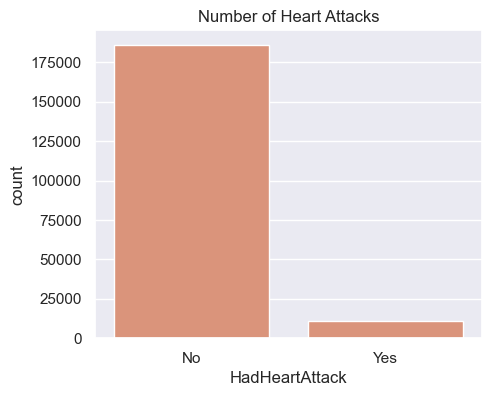

In [8]:
plt.figure(figsize=(5, 4))
plt.title('Number of Heart Attacks')
sns.countplot(x=train_set[target])



The target variable, **HadHeartAttack, is highly imbalanced** in this dataset. However, the dataset contains a substantial number of entries, which gives us the opportunity to implement **undersampling** techniques. This approach would help to balance the classes while still maintaining enough data for effective model training and evaluation.

### Features comprenhension

The dataset comprises a substantial number of columns - 40 in total - which presents a rich array of information for analysis. Despite this considerable size, it remains a manageable quantity for visual inspection. This allows us to effectively explore and comprehend the various values and distributions within each column, facilitating a thorough understanding of the dataset's characteristics. By carefully examining these columns, we can uncover meaningful insights and patterns that will enhance our analysis.

In [9]:
train_set.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [10]:
# unique values of each colum
for column in train_set.columns:
    print(train_set[column].value_counts(), end='\n\n')

State
Washington              11997
Minnesota                7321
Maryland                 7260
Ohio                     7163
New York                 7145
Texas                    5945
Florida                  5907
Kansas                   4925
Wisconsin                4913
Maine                    4804
Iowa                     4564
Virginia                 4495
Hawaii                   4485
South Carolina           4480
Indiana                  4419
Massachusetts            4351
Arizona                  4320
Michigan                 4303
Utah                     4293
Colorado                 4134
Nebraska                 4118
California               4048
Connecticut              4014
Georgia                  4004
Vermont                  3849
South Dakota             3532
Montana                  3430
Missouri                 3299
New Jersey               3180
New Hampshire            3017
Puerto Rico              2884
Idaho                    2765
Alaska                   2542
Rhod

By examining the unique values of each feature, we can make an initial interpretation regarding their classification as either numerical or categorical features. 

For the categorical features, we can further assess whether they are suitable candidates for one-hot encoding or ordinal encoding, depending on whether there is a meaningful order among the categories. This preliminary analysis is crucial for determining the most appropriate encoding methods to apply in subsequent stages of the data processing pipeline.

In [11]:
# all binary columns --> Warning: target included
[col for col in train_set.columns if train_set[col].nunique() == 2]

['Sex',
 'PhysicalActivities',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'ChestScan',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'HighRiskLastYear']

In [12]:
# categorical features with no ordinal meaning
cols_onehot = ['State',
               'Sex',
               'RaceEthnicityCategory',
               'TetanusLast10Tdap',
               'CovidPos']

# binary features
cols_no_yes = [col for col in train_set.columns if train_set[col].nunique() == 2 and col not in ([target] + cols_onehot)]

# categorical columns with ordinal meaning
cols_ordinal = ['GeneralHealth', 
                'LastCheckupTime', 
                'RemovedTeeth',
                'HadDiabetes', 
                'SmokerStatus',
                'ECigaretteUsage',
                'AgeCategory']

# numerical features. # PhysicalHealthDays, MentalHealthDays and SleepHours could 
# be considered categorical as their values are discrete-integers in this dataset
cols_num = ['PhysicalHealthDays', 
            'MentalHealthDays', 
            'SleepHours',
            'HeightInMeters',
            'WeightInKilograms',
            'BMI']

# total of 39 features
len(cols_no_yes) + len(cols_onehot) + len(cols_ordinal) + len(cols_num)


39

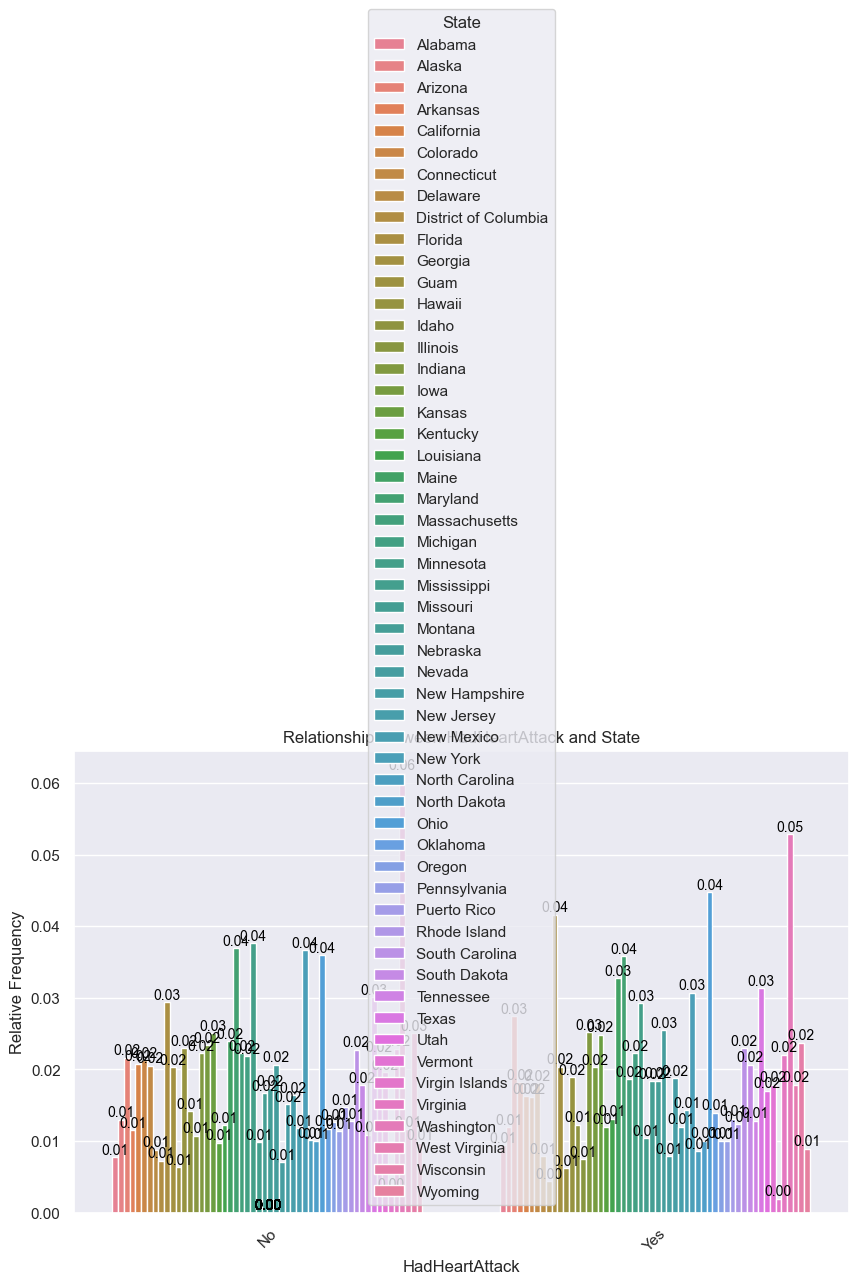

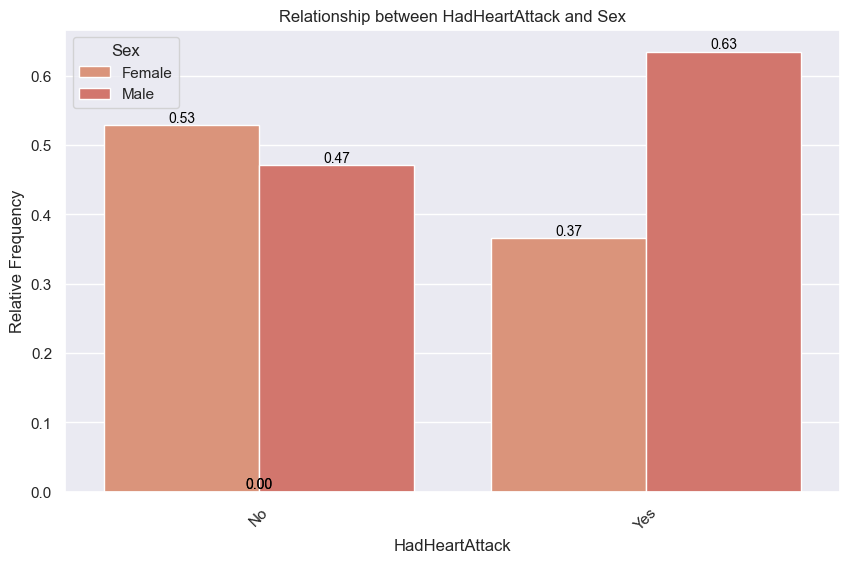

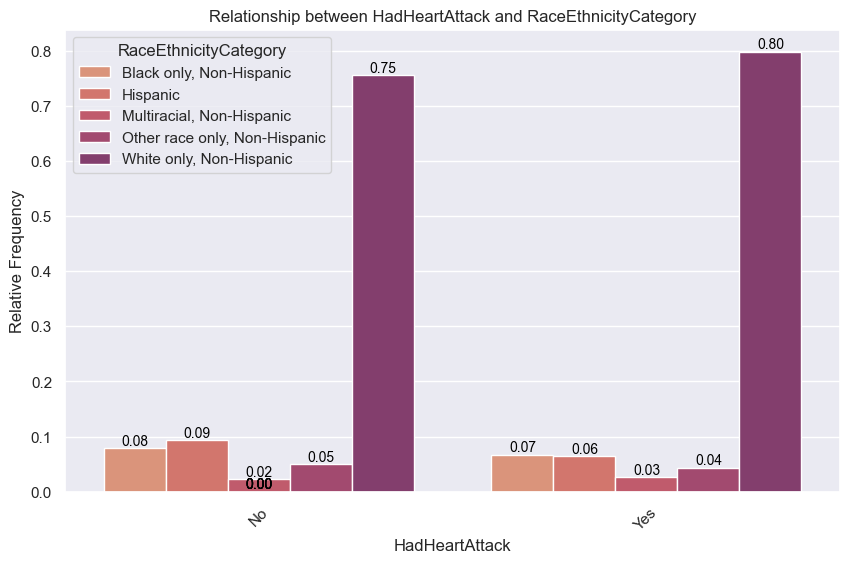

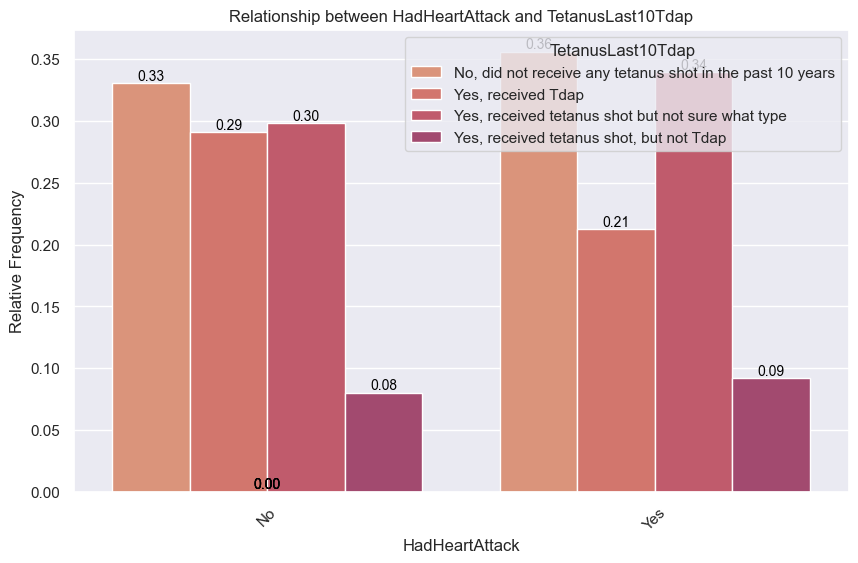

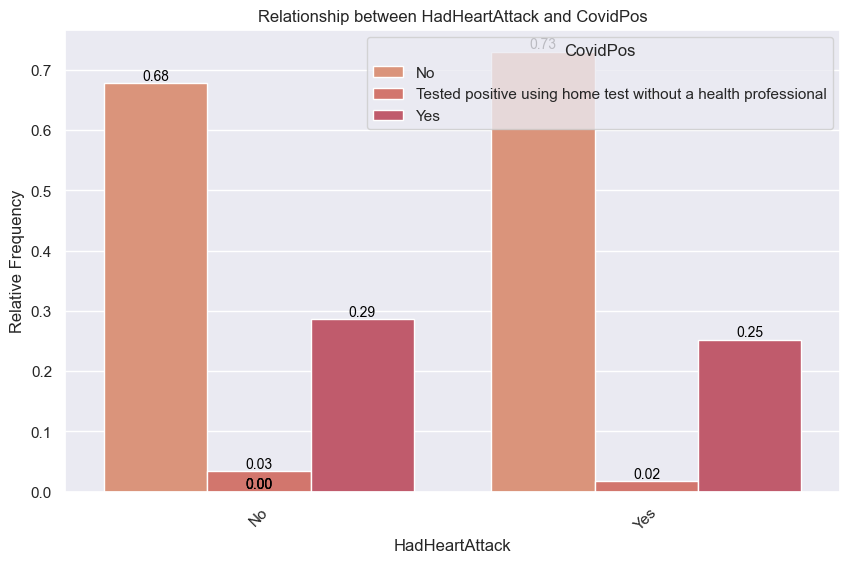

In [13]:
# categorical-categorical relationship
for col in cols_onehot:
    viz.plot_categorical_relationship(train_set,
                                      target,
                                      col,
                                      relative_freq=True)
    

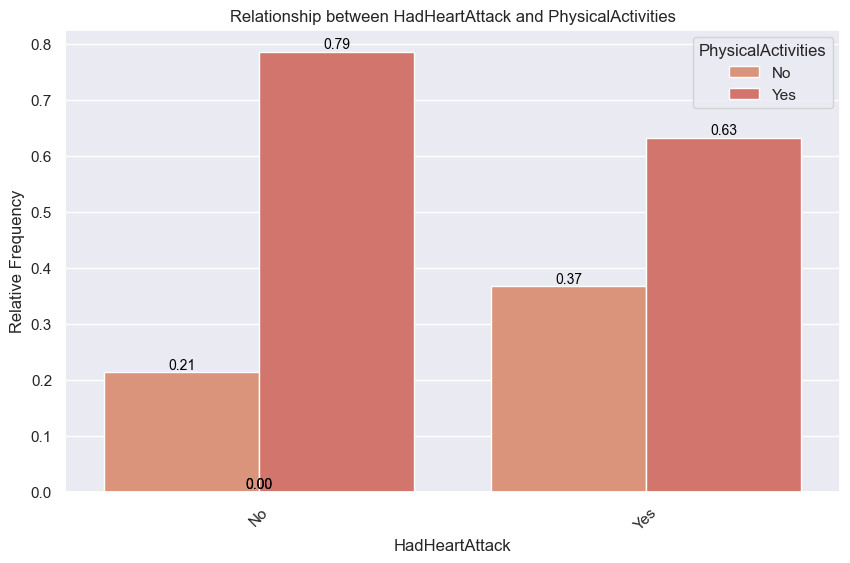

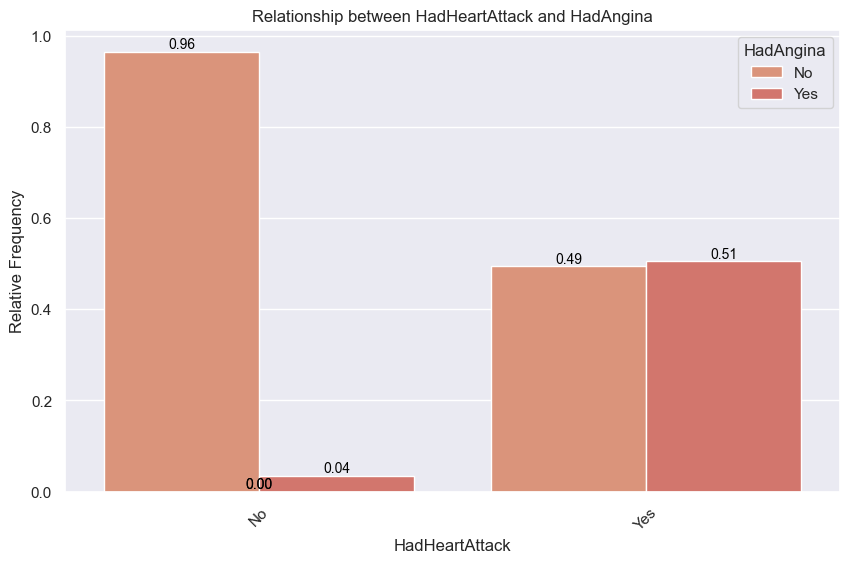

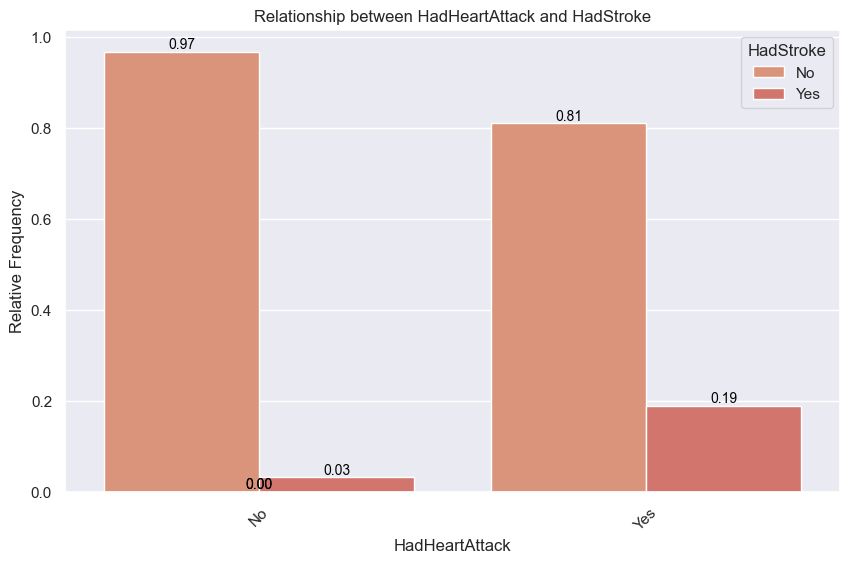

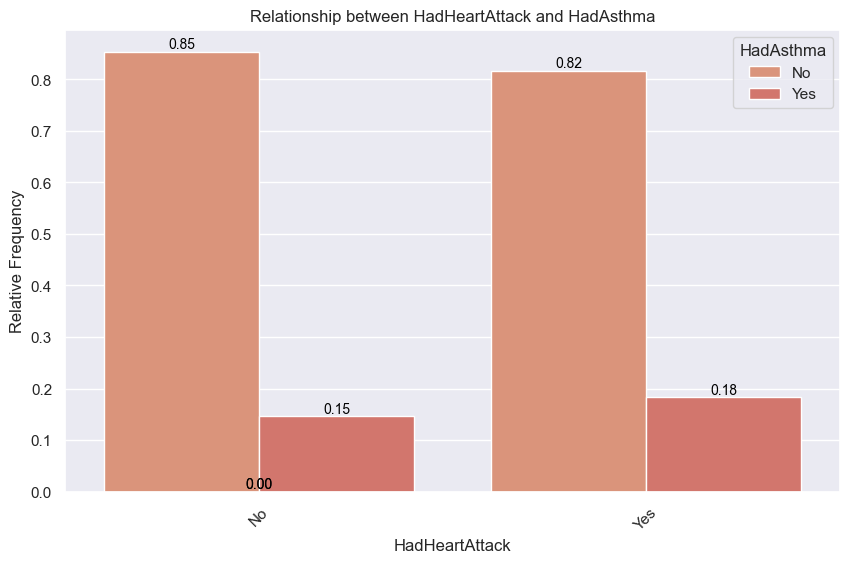

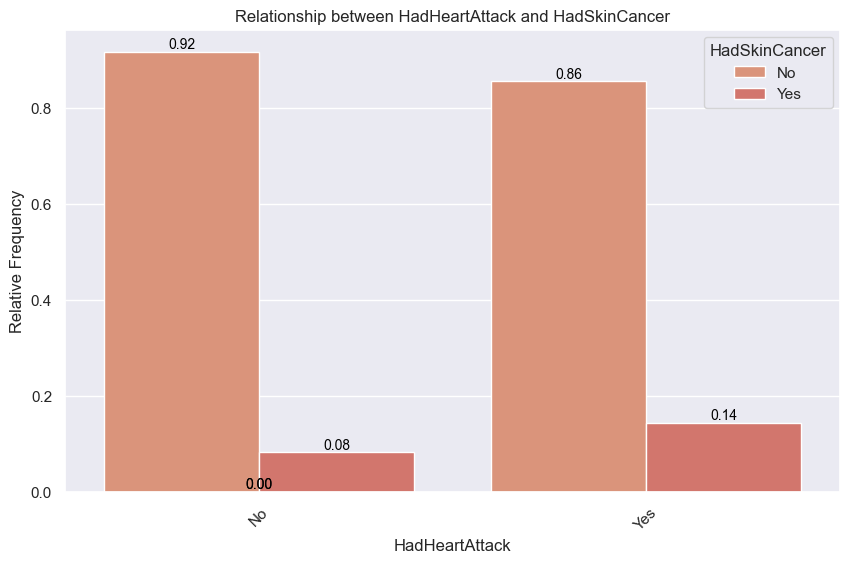

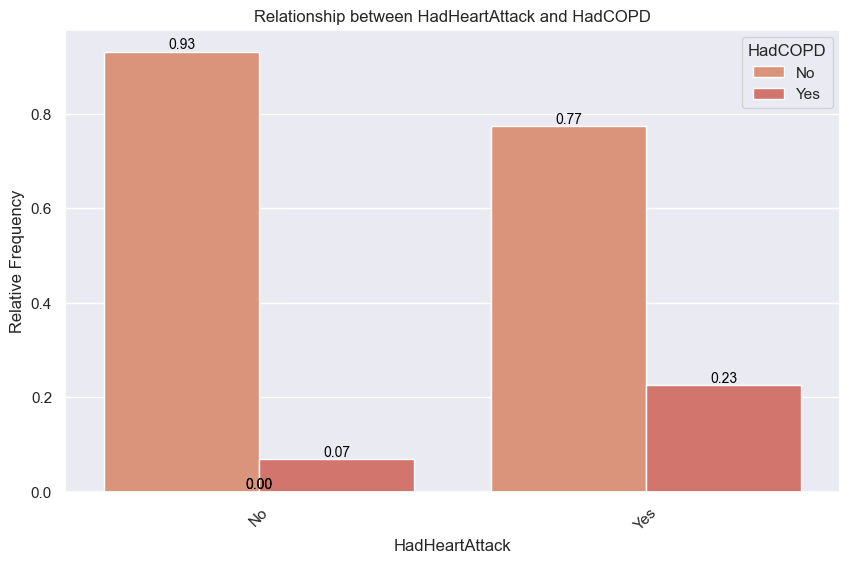

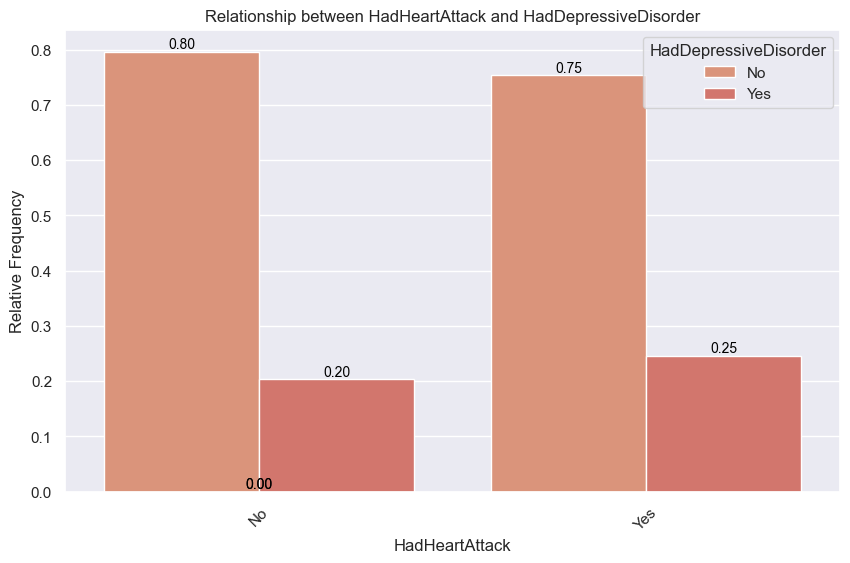

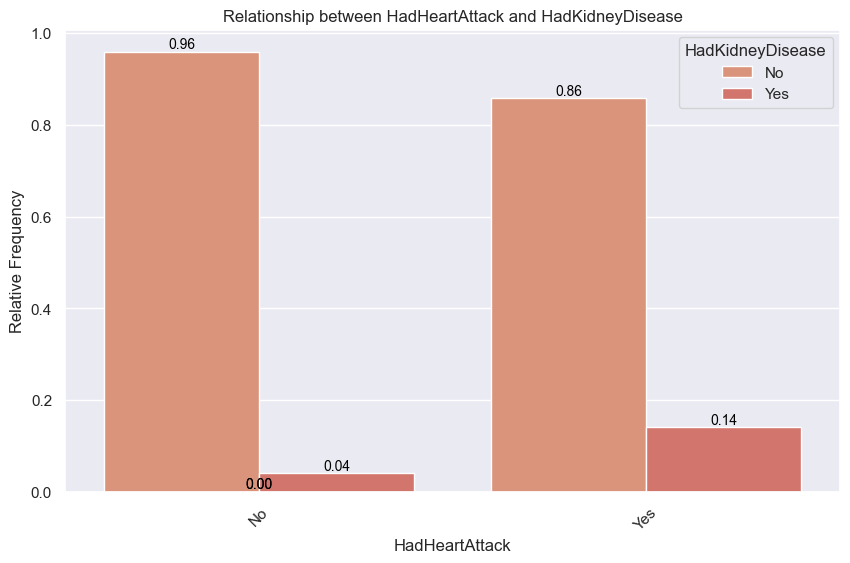

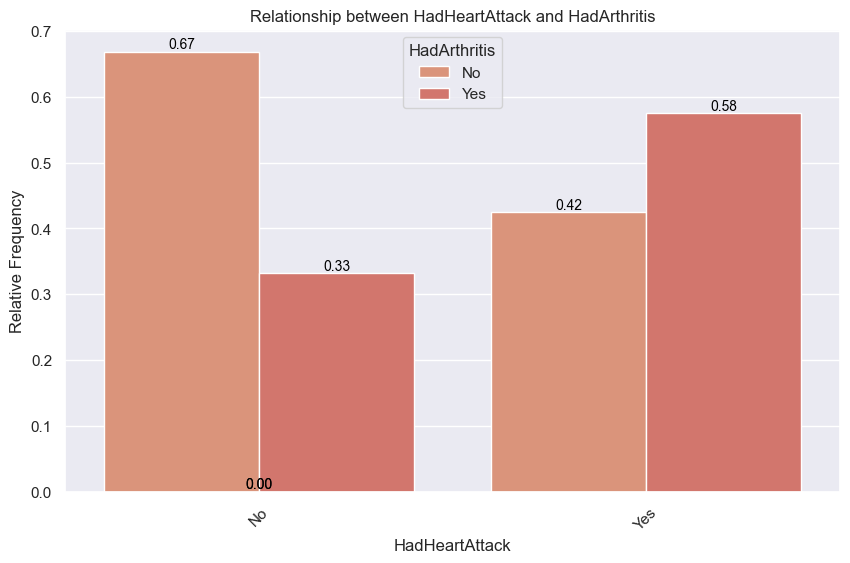

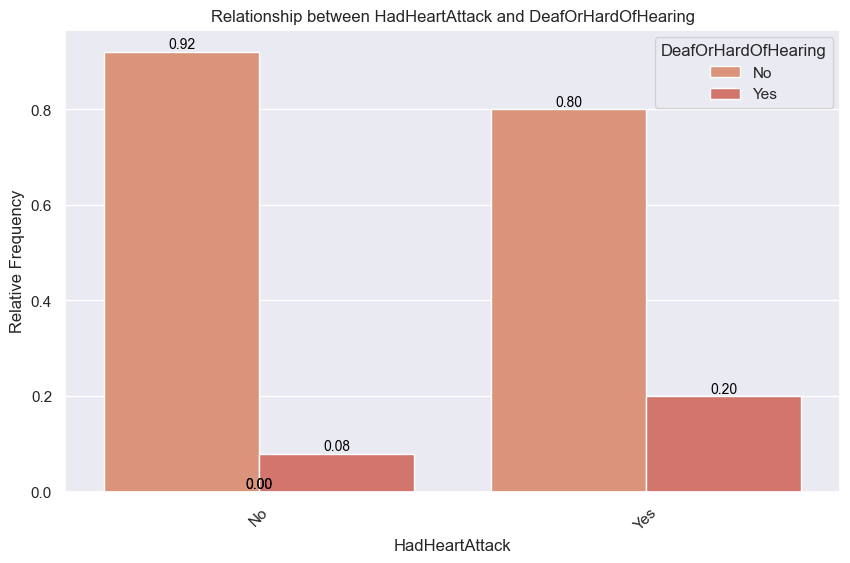

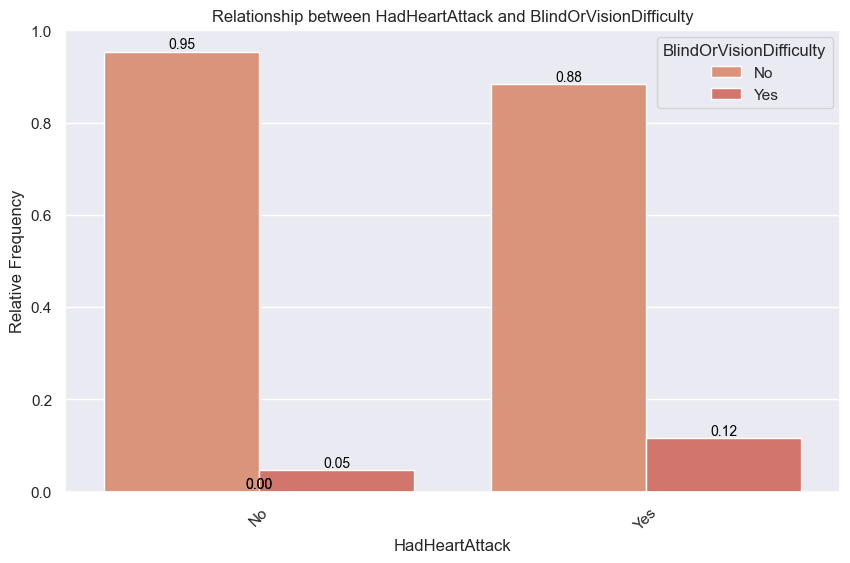

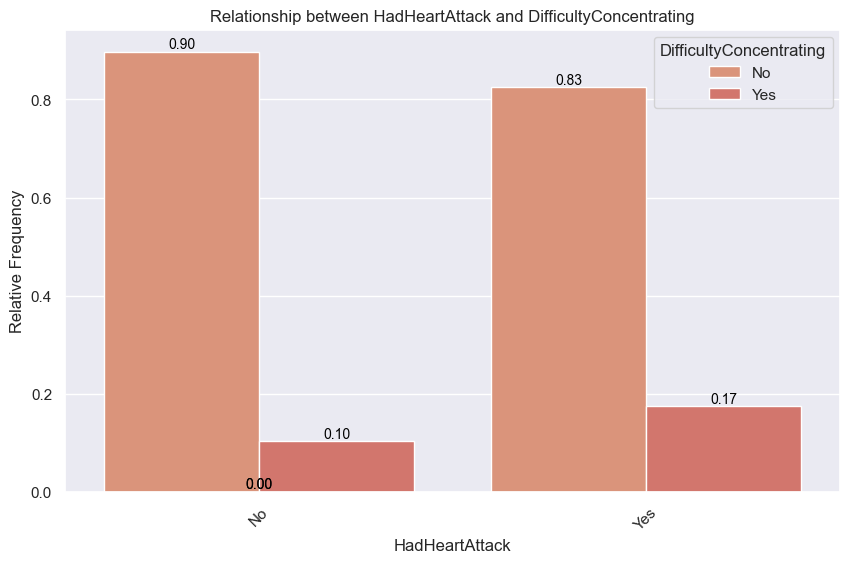

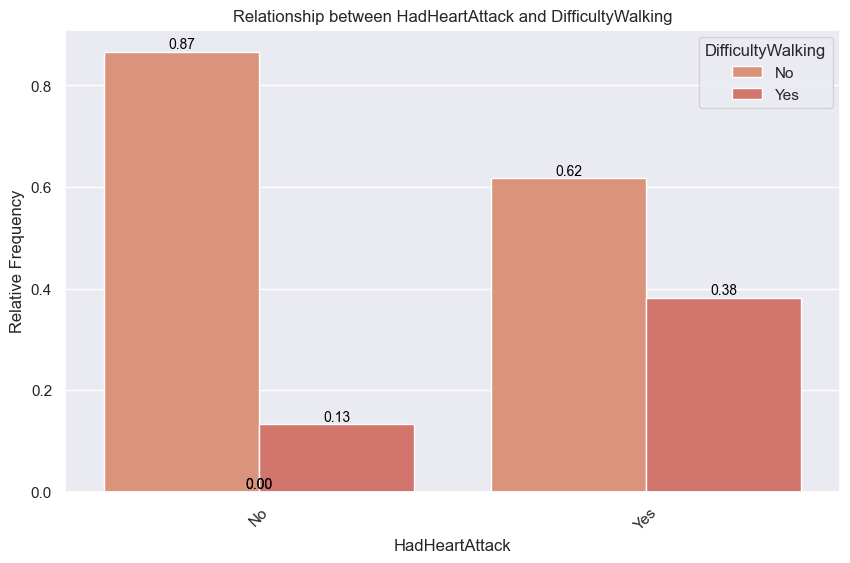

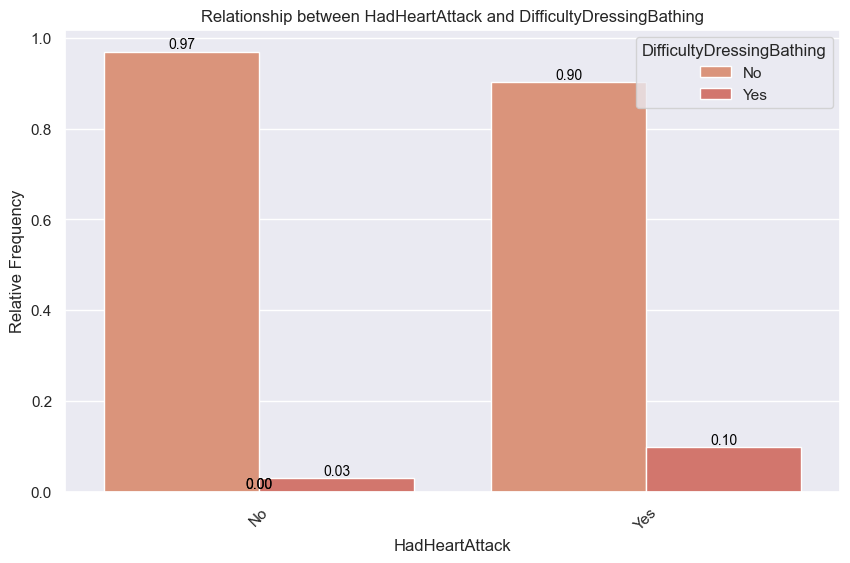

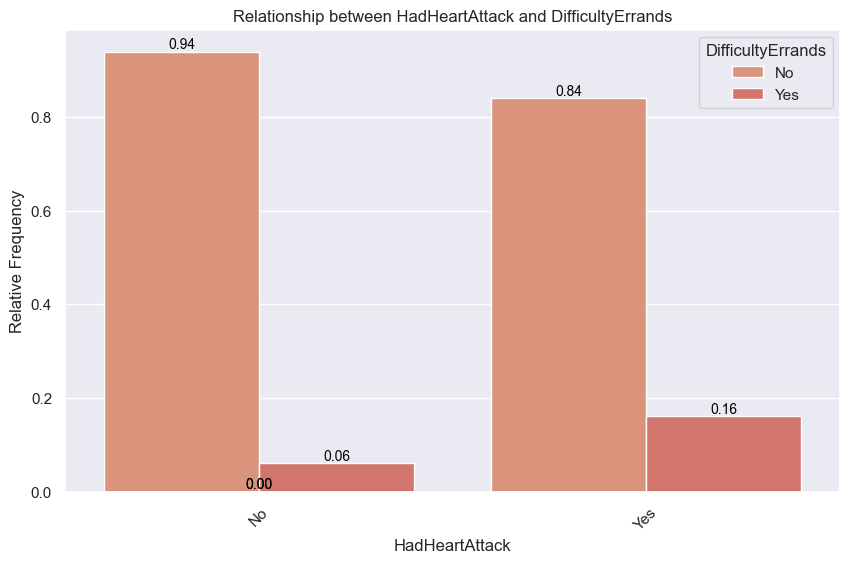

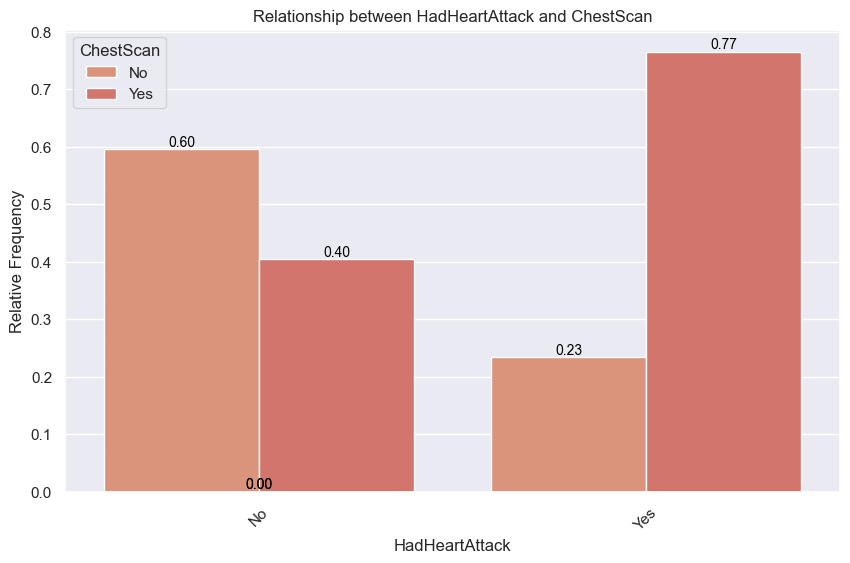

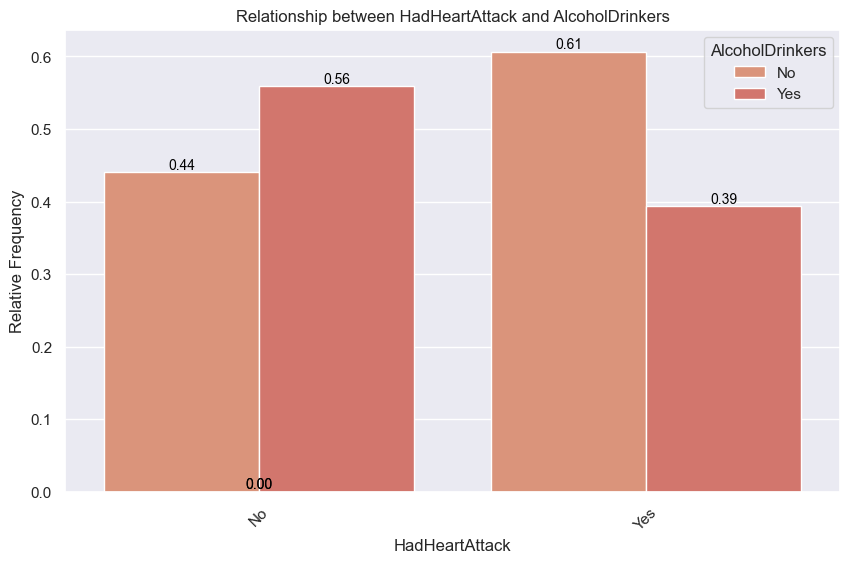

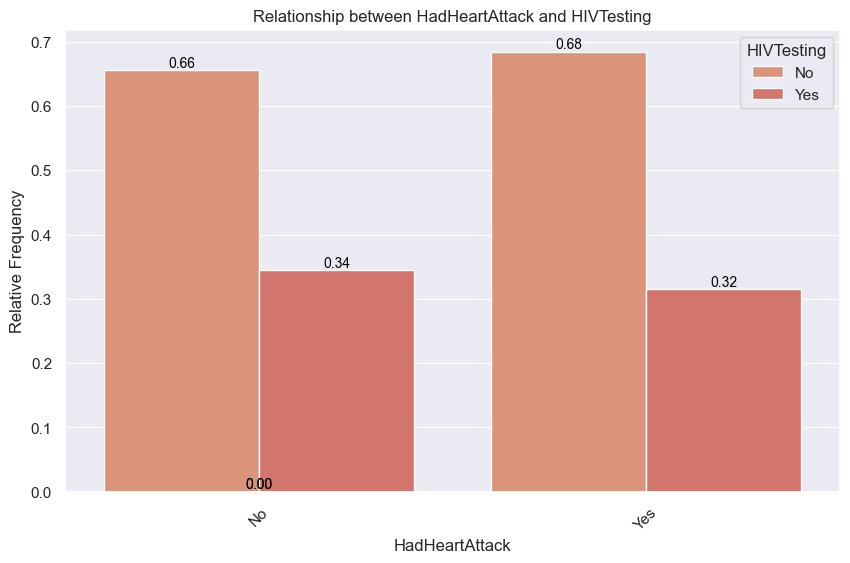

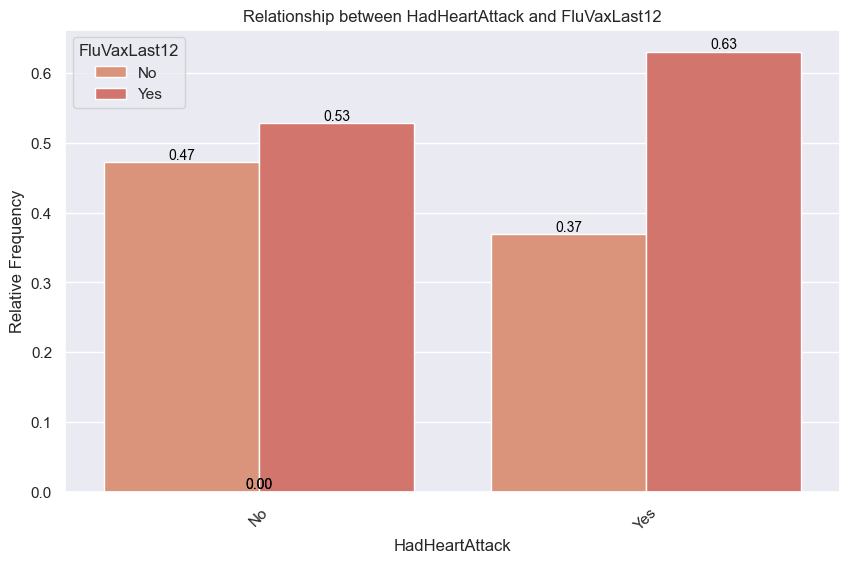

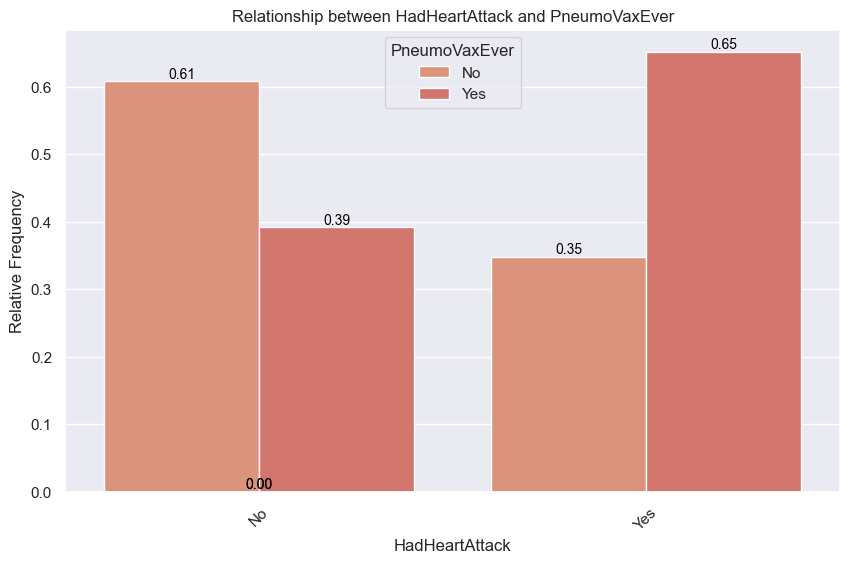

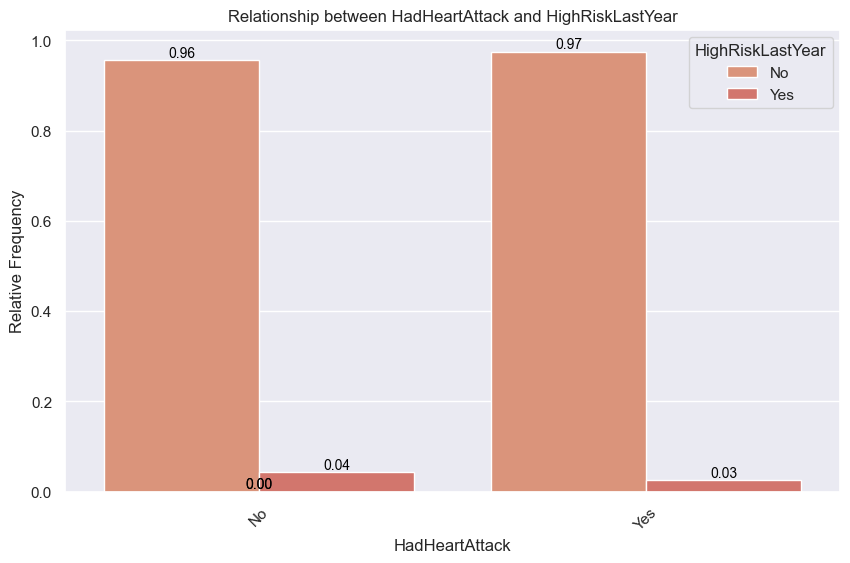

In [14]:
# categorical-categorical relationship
for col in cols_no_yes:
    viz.plot_categorical_relationship(train_set,
                                      target,
                                      col,
                                      relative_freq=True)

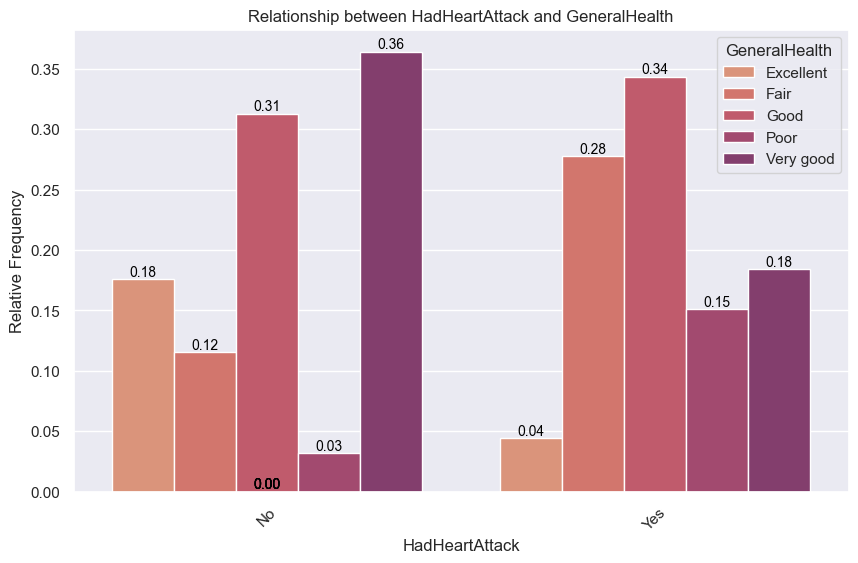

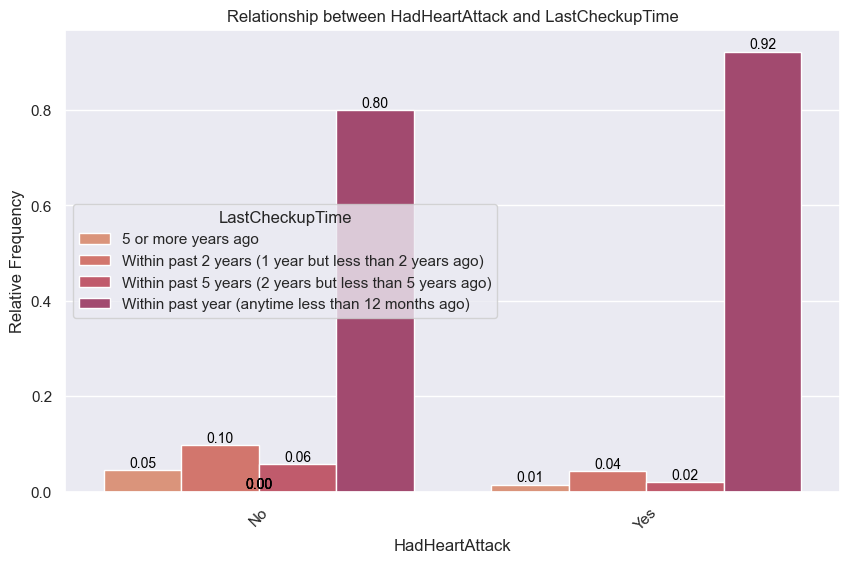

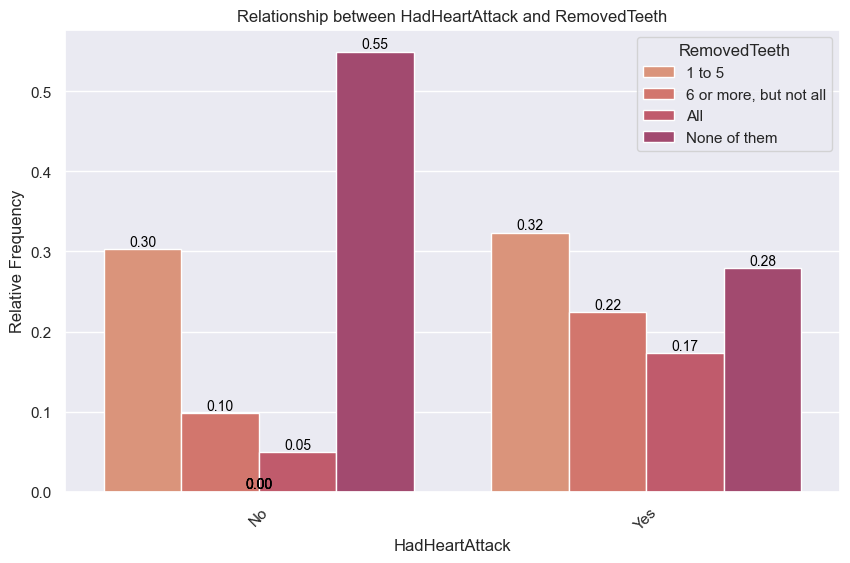

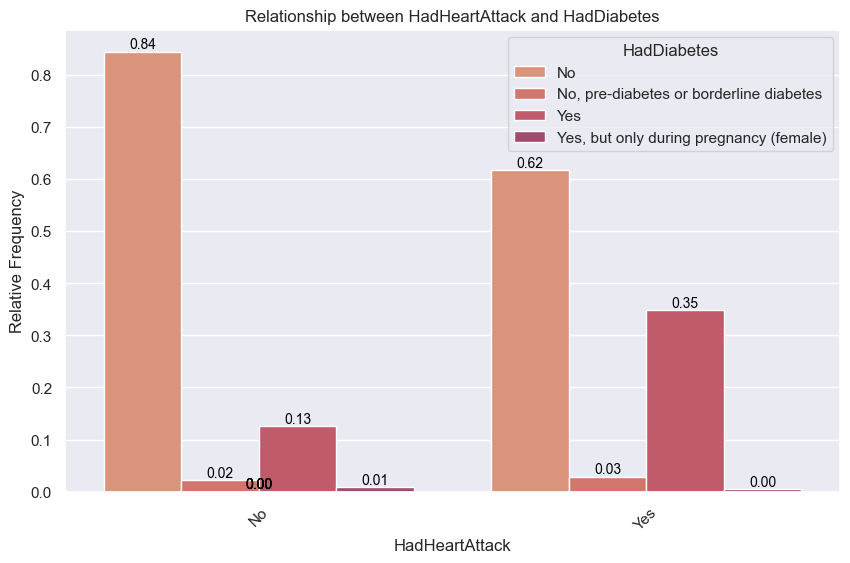

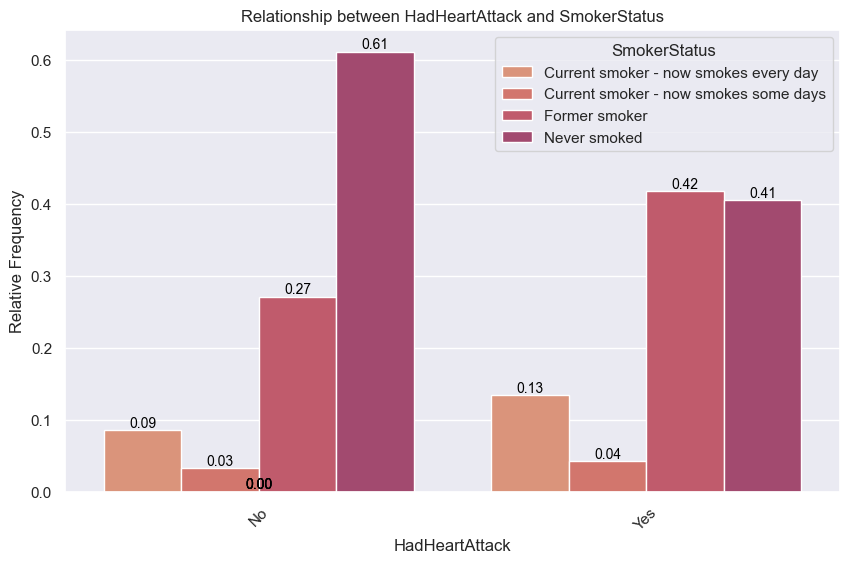

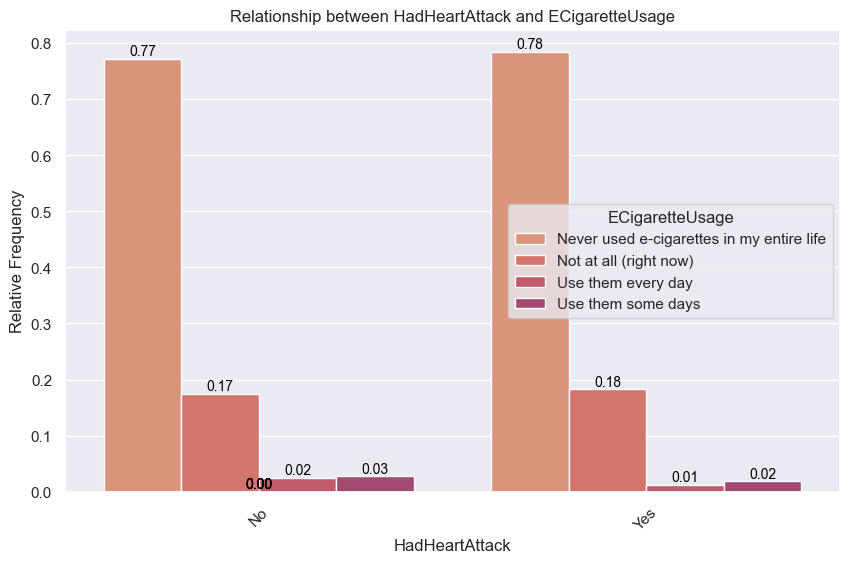

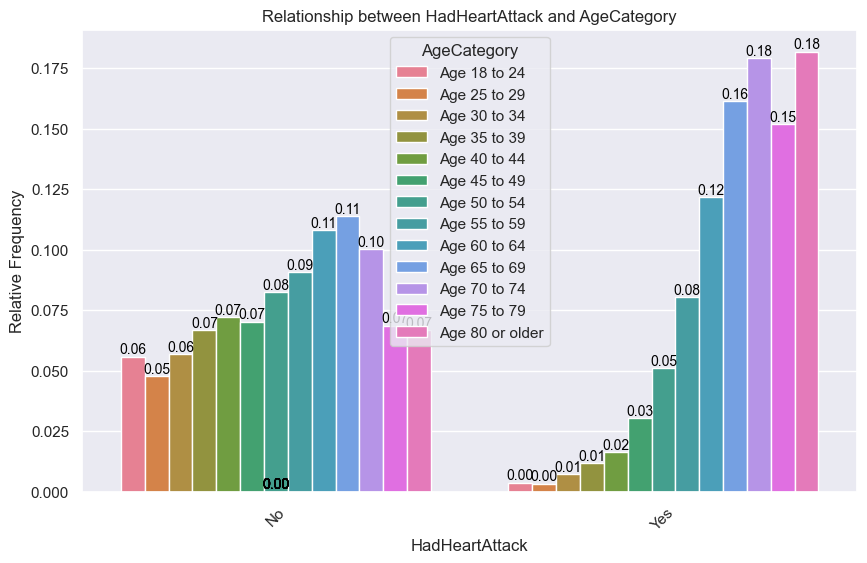

In [15]:
# categorical-categorical relationship
for col in cols_ordinal:
    viz.plot_categorical_relationship(train_set,
                                      target,
                                      col,
                                      relative_freq=True)

After reviewing these categorical features, we determined that several some of them could unlikely contribute significantly to predict heart attack risk.

- State: Although this variable may have some relationship with heart attack risk due to geographic health trends, our objective is not to conduct a geographic analysis. Therefore, we will exclude it from our model.

- HadAsthma, RaceEthnicityCategory, HighRiskLastYear, and ECigaretteUsage: These variables do not appear to have a strong relationship (just in the visual inspection) with heart attack probability based on preliminary analysis, suggesting they may not provide meaningful predictive value in our model.

As a result, we may consider excluding these features from our model to improve its focus and efficiency.

### Numerical Features

Note: PhysicalHealthDays, MentalHealthDays and SleepHours coulb be treated as categorical variables, prior analysis has shown that doing so does not improve prediction accuracy.

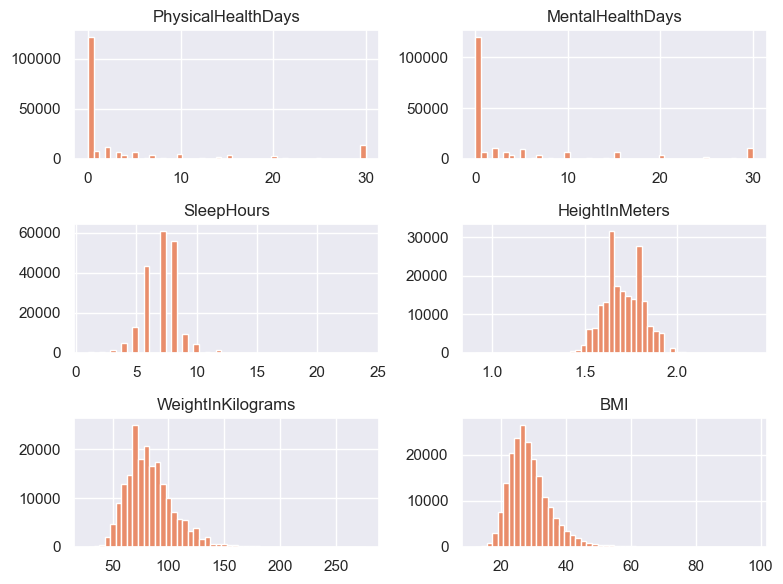

In [16]:
# numerical features distribution
train_set[cols_num].hist(bins=50, figsize=(8, 6));
plt.tight_layout();
plt.show()

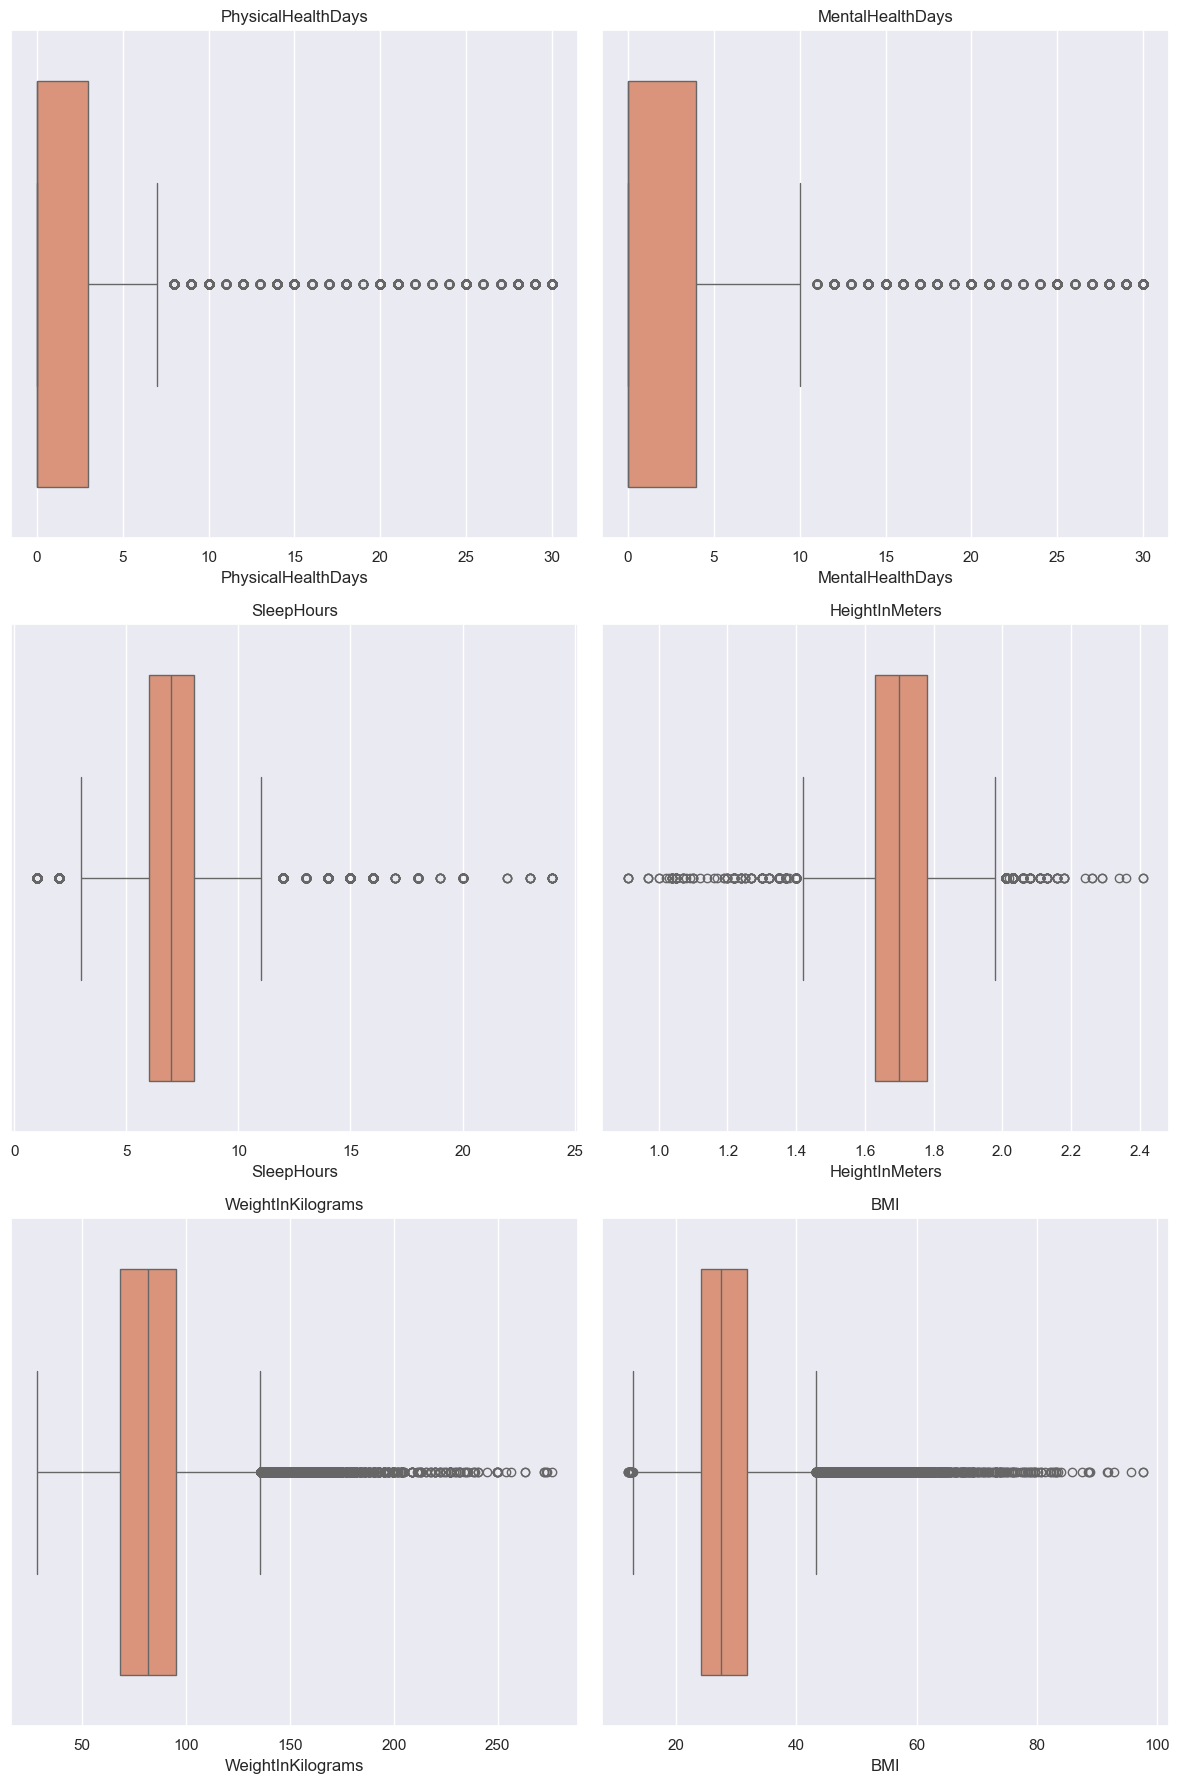

In [17]:
# outliers inspection
viz.boxplot_multiple(train_set, cols_num)

We do have features with outliers but they are valid values (e.g., they accurately reflect extreme but real cases in the population), so they will not be deleted. Removing these values could reduce the dataset's representativeness.

In addition, some algorithms, like tree-based models, are less affected by outliers and can incorporate them without significant issues.


It would be particularly beneficial to have a more Gaussian-like distribution for features when using models that are sensitive to scales, such as logistic regression or SVM. These models assume that the features are normally distributed, and non-linear transformations can help meet these assumptions, improving model performance and stability.


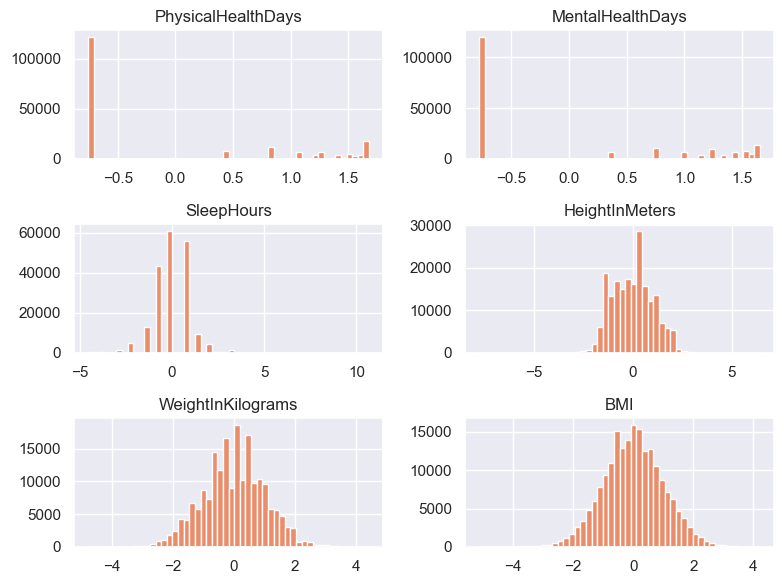

In [18]:
# features Gussian-like transformation
pd.DataFrame(
    PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(train_set[cols_num]), 
    columns=train_set[cols_num].columns
    ).hist(bins=50, figsize=(8, 6))

plt.tight_layout()
plt.show()


However, for models like Random Forests, which are based on tree structures, the distribution of the data is less critical. Random Forests are not sensitive to feature scaling or normality, as they rely on splitting the data based on feature values rather than mathematical assumptions. While transformations may still improve interpretability or help reduce outliers, it is generally not necessary to apply them for Random Forests to perform well.

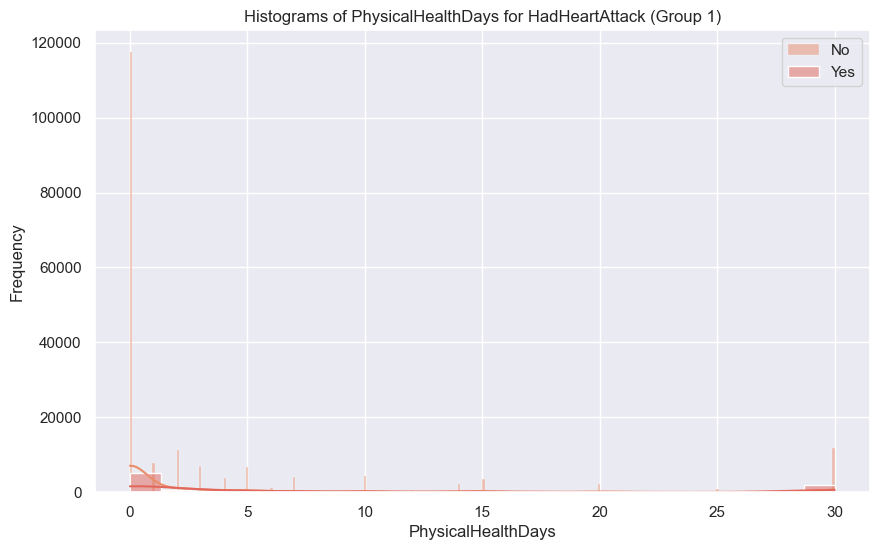

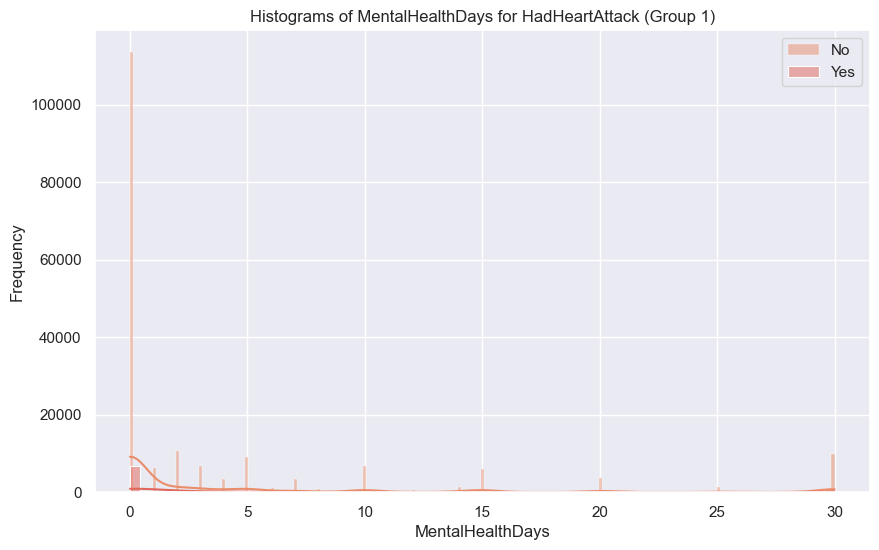

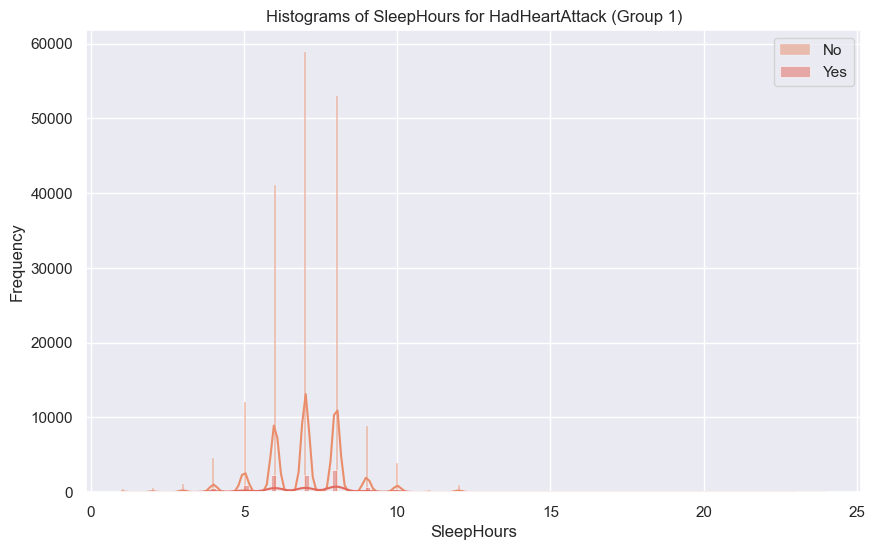

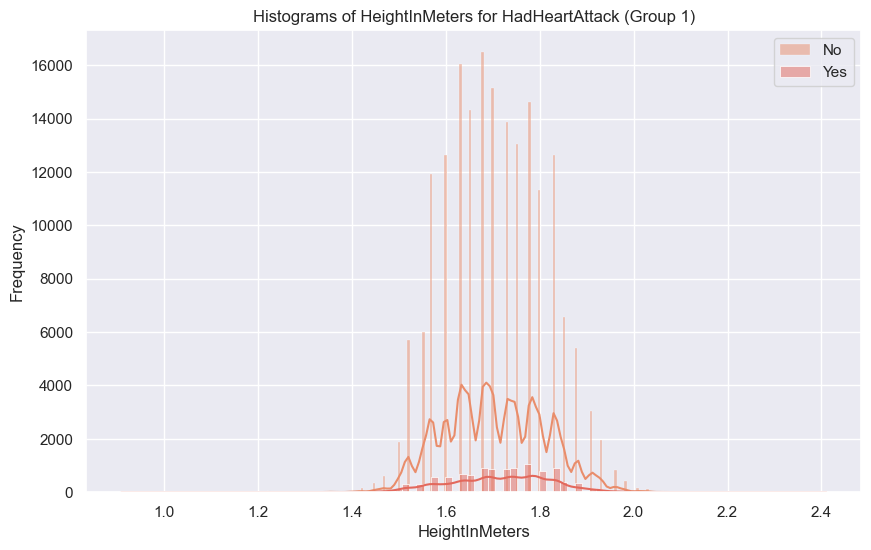

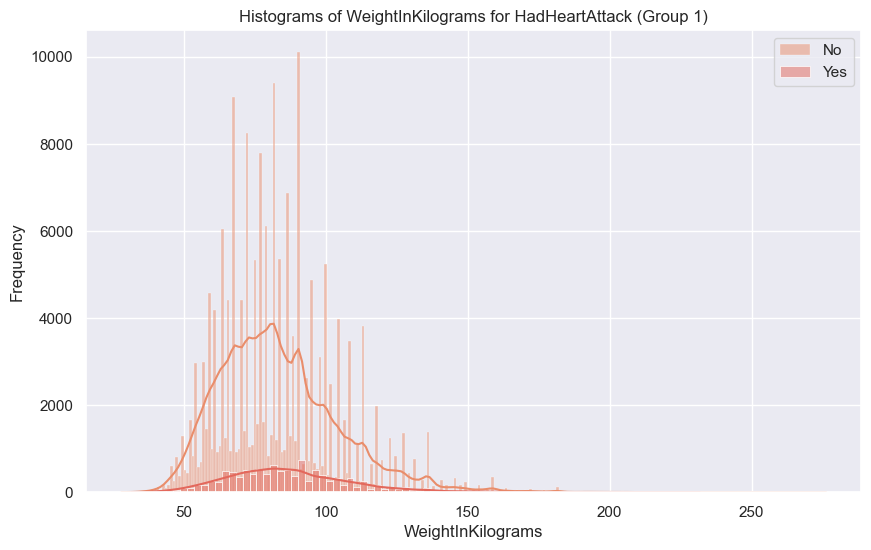

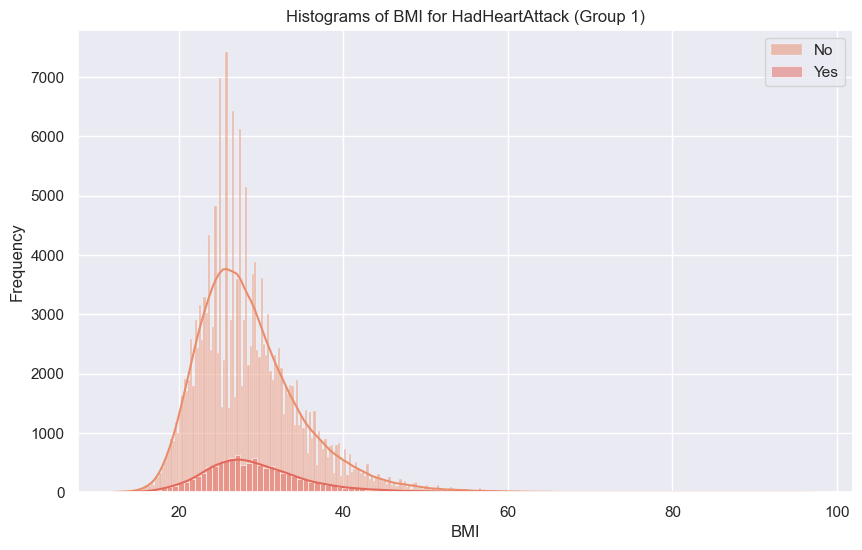

In [19]:
# numerical-categorical relationship
for col in cols_num:
    viz.plot_histograms_grouped(train_set, target, col)

It is important to analyze collinearity among numerical features because highly correlated variables can lead to multicollinearity, which can distort the performance of certain models, particularly linear models. When features are highly correlated, the model may struggle to distinguish their individual contributions, leading to instability in coefficient estimates and reduced interpretability.


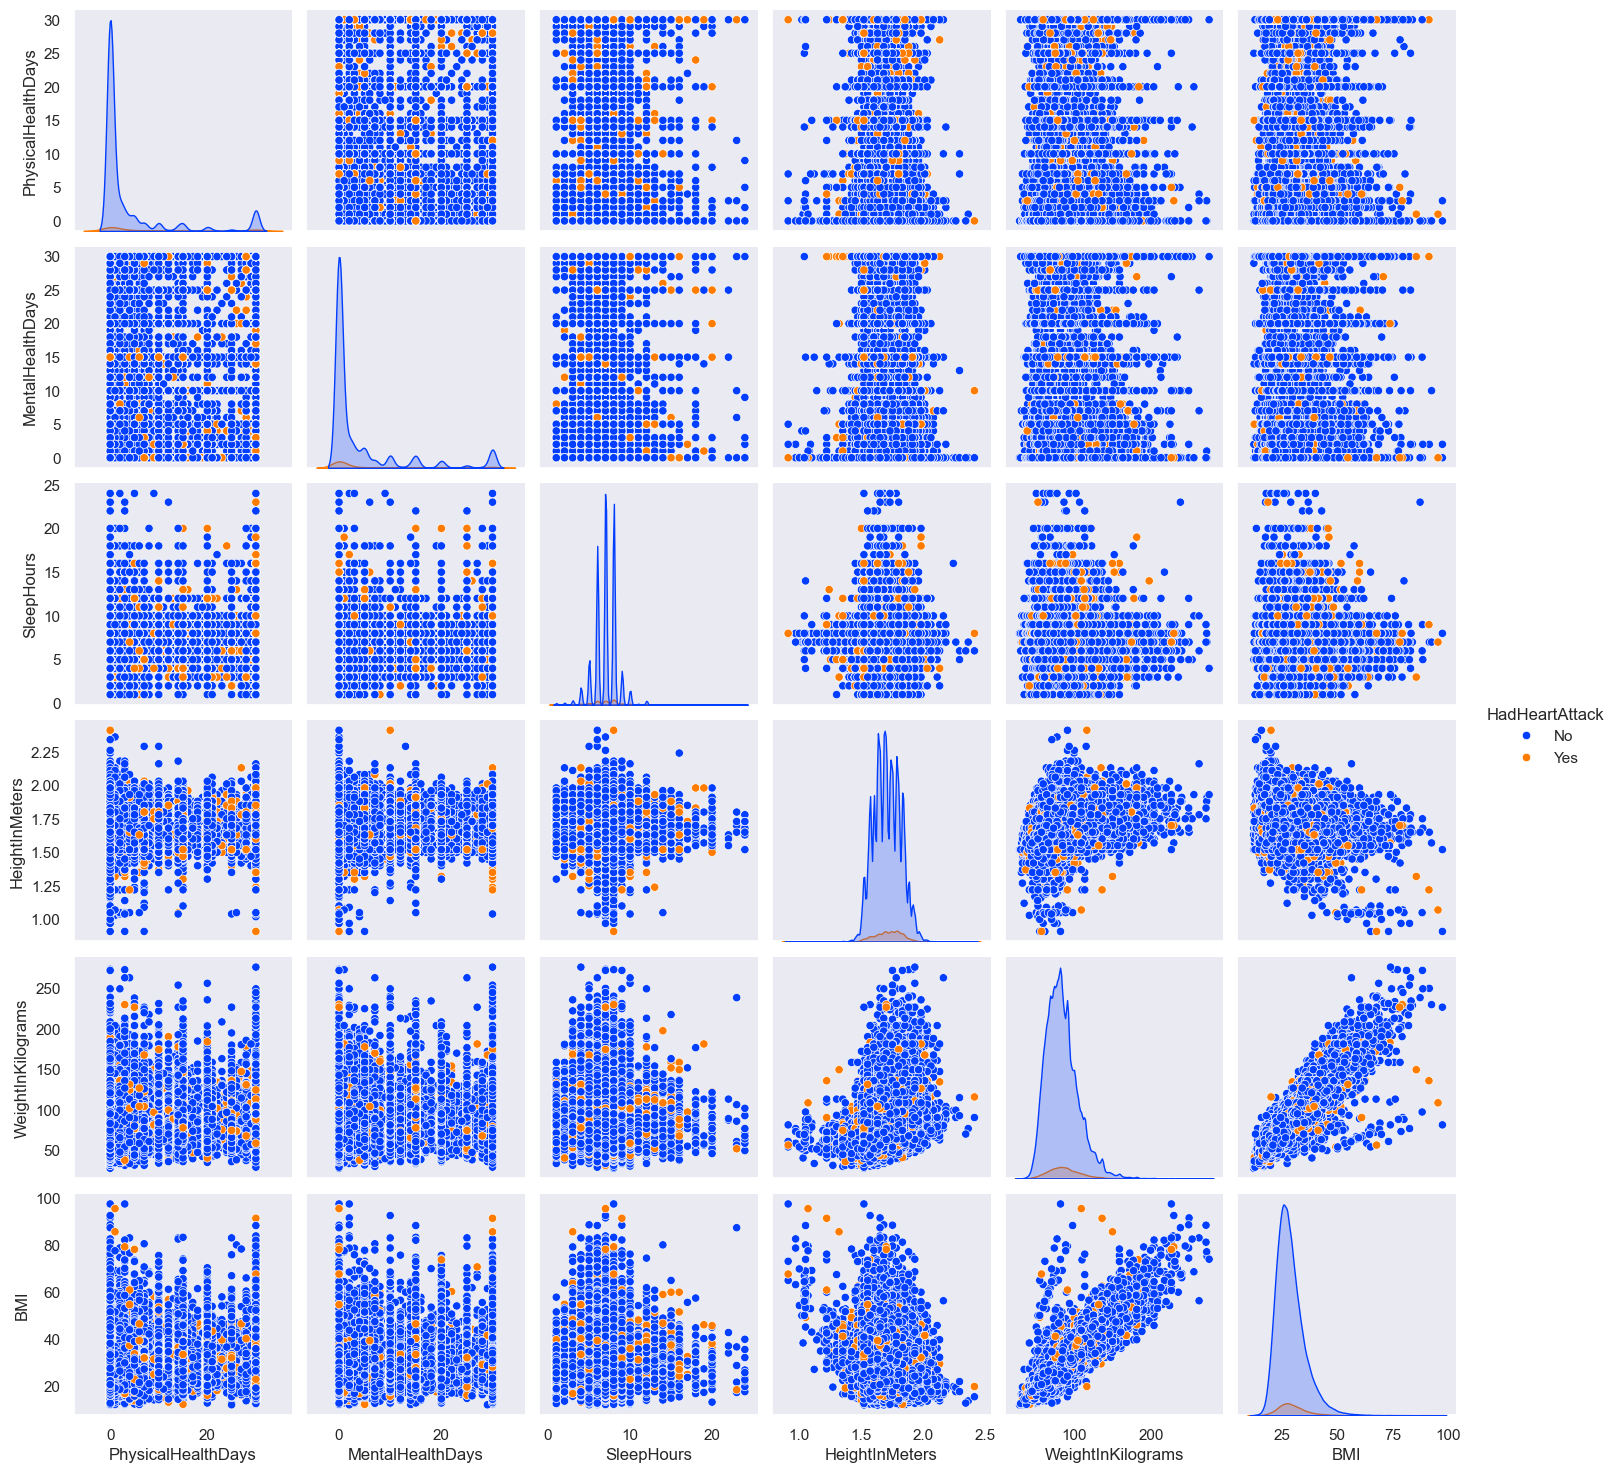

In [20]:
# modern style
sns.set_theme(style='dark', palette='bright')

# target-numerical features relationship
sns.pairplot(data=train_set[cols_num + [target]], hue=target);

In [21]:
# numerical collinearity
display(train_set[cols_num].corr())


PhysicalHealthDays  MentalHealthDays  SleepHours  \
PhysicalHealthDays            1.000000          0.306033   -0.056086   
MentalHealthDays              0.306033          1.000000   -0.131631   
SleepHours                   -0.056086         -0.131631    1.000000   
HeightInMeters               -0.049221         -0.057522   -0.012474   
WeightInKilograms             0.077858          0.040980   -0.055165   
BMI                           0.117420          0.081225   -0.054540   

                    HeightInMeters  WeightInKilograms       BMI  
PhysicalHealthDays       -0.049221           0.077858  0.117420  
MentalHealthDays         -0.057522           0.040980  0.081225  
SleepHours               -0.012474          -0.055165 -0.054540  
HeightInMeters            1.000000           0.474277 -0.026091  
WeightInKilograms         0.474277           1.000000  0.859369  
BMI                      -0.026091           0.859369  1.000000

We could already anticipate that BMI (Body Mass Index) is likely be related to WeightInKilograms, as it is a derived metric. Including both weight and height as separate features, along with BMI, might introduce redundancy and multicollinearity. Identifying such relationships early allows us to make informed decisions, such as removing or combining correlated features to improve model performance and avoid overfitting.

Based on the visual analysis of the grouped histograms, where the distribution of a numerical column is shown for each unique category of a categorical column, it looks like all the features are important. 

While some features may show weaker relationships with the target variable, they still provide distinct information across different categories. This suggests that each feature could contribute valuable insights, even if the strength of their individual effect varies, and thus none can be fully excluded at this stage. 

Further statistical analysis or feature selection methods might be necessary to refine which features should be kept or discarded.

## Feature transformation

The dataset contains a large number of categorical variables, and most machine learning models require numerical inputs to function effectively. While some models, such as decision trees and random forests, can handle categorical variables directly, most others, need these variables to be transformed into numerical representations. 

Therefore, we will apply appropriate encoding techniques, such as one-hot encoding or ordinal encoding, to convert the categorical features into a numerical format, ensuring compatibility with a wider range of models.

Additionally, we will simplify the unique values of certain features to reduce complexity and improve model efficiency.


In [22]:
# back-up
train_set_original = train_set.copy()


In [23]:
# mapping dictionaries to simplify the values of some features
RACE_MAP = {
    'White only, Non-Hispanic': 'White',
    'Hispanic': 'Hispanic',
    'Black only, Non-Hispanic': 'Black',
    'Other race only, Non-Hispanic': 'Other',
    'Multiracial, Non-Hispanic': 'Multiracial'
}

TETANUS_MAP = {
    'No, did not receive any tetanus shot in the past 10 years': 'No',
    'Yes, received tetanus shot but not sure what type': 'YesUnsure',
    'Yes, received Tdap': 'YesTdap',
    'Yes, received tetanus shot, but not Tdap': 'YesNotTdap'
}

COVID_MAP = {
    'No': 'No',
    'Yes': 'Yes',
    'Tested positive using home test without a health professional': 'YesHome'
}

NO_YES_MAP = {
    'No': 0,
    'Yes': 1
}

In [24]:
# ordered list for the ordinal encoders (from "bad" to "good")
GEN_HEALTH = [
    'Poor',
    'Fair', 
    'Good', 
    'Very good', 
    'Excellent'
]

LAST_CHECKUP = [
    '5 or more years ago',
    'Within past 5 years (2 years but less than 5 years ago)',
    'Within past 2 years (1 year but less than 2 years ago)',
    'Within past year (anytime less than 12 months ago)'
]

REMOVED_TEETH = [
    'All',
    '6 or more, but not all',
    '1 to 5',
    'None of them'
]

DIABETES = [
    'Yes',
    'Yes, but only during pregnancy (female)',
    'No, pre-diabetes or borderline diabetes',
    'No'    
]

SMOKER_STATUS = [
    'Current smoker - now smokes every day',
    'Current smoker - now smokes some days',
    'Former smoker',
    'Never smoked'
]

ECIGARETTES = [
    'Use them every day',
    'Use them some days',
    'Not at all (right now)',
    'Never used e-cigarettes in my entire life'
]

# from younger to older
AGE_CATEGORY = [
    'Age 18 to 24', 
    'Age 25 to 29', 
    'Age 30 to 34', 
    'Age 35 to 39', 
    'Age 40 to 44', 
    'Age 45 to 49', 
    'Age 50 to 54', 
    'Age 55 to 59', 
    'Age 60 to 64', 
    'Age 65 to 69', 
    'Age 70 to 74', 
    'Age 75 to 79', 
    'Age 80 or older'
]


### X, y Split

In [25]:
# split X, y, and remove "State" because we are not interested in region information
X_train_original = train_set_original.drop(columns=[target, 'State'])
y_train_original = train_set_original[target]

### Undersampling

In [26]:
# undersampling and shuffling
undersampler = RandomUnderSampler(random_state=random_state)
X_train, y_train = undersampler.fit_resample(X_train_original, y_train_original)
X_train, y_train = shuffle(X_train, y_train, random_state=random_state)


In [27]:
# new target distribution
y_train.value_counts(False)

HadHeartAttack
Yes    10748
No     10748
Name: count, dtype: int64

In [28]:
# apply mapping to improve data comprenhension
X_train['RaceEthnicityCategory'] = X_train['RaceEthnicityCategory'].map(RACE_MAP)
X_train['TetanusLast10Tdap'] = X_train['TetanusLast10Tdap'].map(TETANUS_MAP)
X_train['CovidPos'] = X_train['CovidPos'].map(COVID_MAP)

# one-hot encoding
X_train = pd.get_dummies(X_train, 
                         columns=[col for col in cols_onehot if col != 'State'], 
                         drop_first=False,
                         dtype=int)

# yes-no (one-hot) encoding
X_train[cols_no_yes] = X_train[cols_no_yes].apply(lambda x: x.map(NO_YES_MAP))
y_train = y_train.map(NO_YES_MAP)

# ordinal encoding
X_train['GeneralHealth'] = OrdinalEncoder(categories=[GEN_HEALTH], dtype=int).fit_transform(X_train[['GeneralHealth']])
X_train['LastCheckupTime'] = OrdinalEncoder(categories=[LAST_CHECKUP], dtype=int).fit_transform(X_train[['LastCheckupTime']])
X_train['RemovedTeeth'] = OrdinalEncoder(categories=[REMOVED_TEETH], dtype=int).fit_transform(X_train[['RemovedTeeth']])
X_train['HadDiabetes'] = OrdinalEncoder(categories=[DIABETES], dtype=int).fit_transform(X_train[['HadDiabetes']])
X_train['SmokerStatus'] = OrdinalEncoder(categories=[SMOKER_STATUS], dtype=int).fit_transform(X_train[['SmokerStatus']])
X_train['ECigaretteUsage'] = OrdinalEncoder(categories=[ECIGARETTES], dtype=int).fit_transform(X_train[['ECigaretteUsage']])
X_train['AgeCategory'] = OrdinalEncoder(categories=[AGE_CATEGORY], dtype=int).fit_transform(X_train[['AgeCategory']])

# numeric features: power transform and standardize
X_train[cols_num] = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(X_train[cols_num])

# diplay
display(X_train.head(5))



GeneralHealth  PhysicalHealthDays  MentalHealthDays  LastCheckupTime  \
191003              2            0.618917          0.773746                3   
127250              1            1.277940          1.379295                3   
6107                0            1.516164          1.124543                3   
57119               2           -0.871696         -0.754120                3   
147735              2           -0.871696          1.441130                2   

        PhysicalActivities  SleepHours  RemovedTeeth  HadAngina  HadStroke  \
191003                   1    -0.61109             1          0          0   
127250                   0     2.84216             1          1          1   
6107                     1    -0.61109             0          1          0   
57119                    1    -3.36810             2          1          0   
147735                   1    -0.61109             2          0          0   

        HadAsthma  HadSkinCancer  HadCOPD  HadDepressiveDisorder  \
191003          0              0        0                      0   
127250          0              0        0                      1   
6107            0              0        0                      0   
57119           0              1        0                      0   
147735          0              0        0                      1   

        HadKidneyDisease  HadArthritis  HadDiabetes  DeafOrHardOfHearing  \
191003                 0             0            0                    1   
127250                 0             0            3                    0   
6107                   0             1            3                    0   
57119                  1             1            0                    0   
147735                 0             1            3                    0   

        BlindOrVisionDifficulty  DifficultyConcentrating  DifficultyWalking  \
191003                        0                        0                  1   
127250                        0                        1                  1   
6107                          1                        0                  1   
57119                         0                        0                  0   
147735                        0                        1                  0   

        DifficultyDressingBathing  DifficultyErrands  SmokerStatus  \
191003                          0                  0             2   
127250                          0                  0             3   
6107                            0                  0             1   
57119                           0                  0             2   
147735                          0                  0             3   

        ECigaretteUsage  ChestScan  AgeCategory  HeightInMeters  \
191003                3          0           12       -0.755859   
127250                3          1            6       -0.296613   
6107                  3          1           11       -1.740522   
57119                 3          1           11       -0.755859   
147735                2          1           11       -0.573034   

        WeightInKilograms       BMI  AlcoholDrinkers  HIVTesting  \
191003           0.144510  0.651735                0           0   
127250          -0.267204 -0.102506                1           1   
6107            -1.223462 -0.296738                1           0   
57119           -0.490952 -0.067442                0           0   
147735          -0.783814 -0.571245                0           0   

        FluVaxLast12  PneumoVaxEver  HighRiskLastYear  Sex_Female  Sex_Male  \
191003             0              0                 0           1         0   
127250             1              0                 0           0         1   
6107               0              0                 0           1         0   
57119              1              1                 0           0         1   
147735             1              1                 0           1         0   

        R

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21496 entries, 191003 to 238581
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GeneralHealth                      21496 non-null  int32  
 1   PhysicalHealthDays                 21496 non-null  float64
 2   MentalHealthDays                   21496 non-null  float64
 3   LastCheckupTime                    21496 non-null  int32  
 4   PhysicalActivities                 21496 non-null  int64  
 5   SleepHours                         21496 non-null  float64
 6   RemovedTeeth                       21496 non-null  int32  
 7   HadAngina                          21496 non-null  int64  
 8   HadStroke                          21496 non-null  int64  
 9   HadAsthma                          21496 non-null  int64  
 10  HadSkinCancer                      21496 non-null  int64  
 11  HadCOPD                            21496 non-null  in

In [30]:
X_train.describe()

GeneralHealth  PhysicalHealthDays  MentalHealthDays  LastCheckupTime  \
count   21496.000000        2.149600e+04      2.149600e+04     21496.000000   
mean        2.114207        8.263662e-17      3.669066e-17         2.757862   
std         1.127561        1.000023e+00      1.000023e+00         0.674552   
min         0.000000       -8.716958e-01     -7.541198e-01         0.000000   
25%         1.000000       -8.716958e-01     -7.541198e-01         3.000000   
50%         2.000000       -8.716958e-01     -7.541198e-01         3.000000   
75%         3.000000        1.037342e+00      1.217420e+00         3.000000   
max         4.000000        1.516164e+00      1.636607e+00         3.000000   

       PhysicalActivities    SleepHours  RemovedTeeth     HadAngina  \
count        21496.000000  2.149600e+04  21496.000000  21496.000000   
mean             0.709574  2.495626e-16      2.033215      0.271539   
std              0.453970  1.000023e+00      1.008784      0.444764   
min              0.000000 -4.184560e+00      0.000000      0.000000   
25%              0.000000 -6.110903e-01      1.000000      0.000000   
50%              1.000000  5.220243e-03      2.000000      0.000000   
75%              1.000000  6.021965e-01      3.000000      1.000000   
max              1.000000  8.712031e+00      3.000000      1.000000   

          HadStroke     HadAsthma  HadSkinCancer       HadCOPD  \
count  21496.000000  21496.000000   21496.000000  21496.000000   
mean       0.110625      0.165659       0.110486      0.148214   
std        0.313675      0.371783       0.313501      0.355320   
min        0.000000      0.000000       0.000000      0.000000   
25%        0.000000      0.000000       0.000000      0.000000   
50%        0.000000      0.000000       0.000000      0.000000   
75%        0.000000      0.000000       0.000000      0.000000   
max        1.000000      1.000000       1.000000      1.000000   

       HadDepressiveDisorder  HadKidneyDisease  HadArthritis   HadDiabetes  \
count           21496.000000      21496.000000  21496.000000  21496.000000   
mean                0.222925          0.091738      0.452224      2.249907   
std                 0.416218          0.288662      0.497724      1.274319   
min                 0.000000          0.000000      0.000000      0.000000   
25%                 0.000000          0.000000      0.000000      2.000000   
50%                 0.000000          0.000000      0.000000      3.000000   
75%                 0.000000          0.000000      1.000000      3.000000   
max                 1.000000          1.000000      1.000000      3.000000   

       DeafOrHardOfHearing  BlindOrVisionDifficulty  DifficultyConcentrating  \
count         21496.000000             21496.000000             21496.000000   
mean              0.139003                 0.080806                 0.138677   
std               0.345957                 0.272543                 0.345617   
min               0.000000                 0.000000                 0.000000   
25%               0.000000                 0.000000                 0.000000   
50%               0.000000                 0.000000                 0.000000   
75%               0.000000                 0.000000                 0.000000   
max               1.000000                 1.000000                 1.000000   

       DifficultyWalking  DifficultyDressingBathing  DifficultyErrands  \
count       21496.000000               21496.000000       21496.000000   
mean            0.256420                   0.063779           0.111183   
std             0.436666                   0.244365           0.314367   
min             0.000000                   0.000000           0.000000   
25%             0.000000                   0.000000           0.000000   
50%             0.000000                   0.000000           0.000000   
75%             1.000000                   0.000000           0.000000   
max             1.000000                   1

In [31]:
# new target distribution
y_train.value_counts(False)

HadHeartAttack
1    10748
0    10748
Name: count, dtype: int64

## Features selection

To select the optimal features for the future model, I will create a dictionary that stores different sets of training data, each with a subset of features selected using various strategies.

This will allow for easy comparison of the performance of the model with different feature combinations and help identify which set of features yields the best results. Each strategy will be based on specific criteria, such as correlation, importance scores, or statistical significance, to ensure a comprehensive approach to feature selection.

In [32]:
# create dictionary of X_train sets
X_train_dict = {}


In [33]:
# complete dataset. No reduction
X_train_dict['full'] = X_train.copy()

len(X_train_dict['full'].columns)

48

Remember, that after visual inspection we choose to delete some features.


In [34]:
# features to exclude after de visual analysis
cols_to_exclude = [
    'HadAsthma', 
    'RaceEthnicityCategory', 
    'HighRiskLastYear', 
    'ECigaretteUsage',
    'HeightInMeters', 
    'WeightInKilograms'
]

cols_to_exclude = [col for col in X_train.columns if any(keyword in col for keyword in cols_to_exclude)]
print('Features to exclude:', cols_to_exclude)

# dataset based on visual analysis
X_train_dict['visual'] = X_train.drop(columns=cols_to_exclude)


Features to exclude: ['HadAsthma', 'ECigaretteUsage', 'HeightInMeters', 'WeightInKilograms', 'HighRiskLastYear', 'RaceEthnicityCategory_Black', 'RaceEthnicityCategory_Hispanic', 'RaceEthnicityCategory_Multiracial', 'RaceEthnicityCategory_Other', 'RaceEthnicityCategory_White']


### Mutual Information

Set of features selected after the analysis of mutual information. Features with higher mutual information scores will be prioritized, as they provide more information about the target. This approach allows us to focus on the most relevant features that contribute significantly to the prediction, while potentially discarding those with weak or no relationship to the target variable.

In [35]:
# mutual information
print('Mutual Information with "HadHeartAttack":', end='\n---\n')
mi_scores = {feat: mutual_info_score(X_train[feat], y_train) for feat in [col for col in X_train.columns if col not in cols_num]}
sorted_mi_scores = sorted(mi_scores.items(), key=lambda x: x[1], reverse=True)
for feat, mi in sorted_mi_scores:
    print(f'{feat}: {mi}')


Mutual Information with "HadHeartAttack":
---
HadAngina: 0.15905238242557826
AgeCategory: 0.09144470683642357
GeneralHealth: 0.07380501301055092
ChestScan: 0.07046414785895763
RemovedTeeth: 0.05471894592479787
DifficultyWalking: 0.042854642420022515
HadDiabetes: 0.03675441417153277
HadStroke: 0.03443403704179034
PneumoVaxEver: 0.0338574820747824
HadArthritis: 0.0309385343830276
HadCOPD: 0.025087452408428287
SmokerStatus: 0.021635668283804907
LastCheckupTime: 0.016179072667702875
DeafOrHardOfHearing: 0.01593195791235312
HadKidneyDisease: 0.015318316079360503
AlcoholDrinkers: 0.015074725952176626
PhysicalActivities: 0.01451319328522635
Sex_Female: 0.012913872575587404
Sex_Male: 0.012913872575587404
DifficultyErrands: 0.01289278585487677
DifficultyDressingBathing: 0.010348096232398511
BlindOrVisionDifficulty: 0.008471517273859211
FluVaxLast12: 0.006369327109137346
HadSkinCancer: 0.005837667868472368
DifficultyConcentrating: 0.005466992977105317
TetanusLast10Tdap_YesTdap: 0.003824454138640

In [36]:
# selecting features based on a MI threshold
mi_threshold = 2e-3  
cat_features_mi = [feat for feat, mi in sorted_mi_scores if mi > mi_threshold]
print(f'Selected features based on MI > {mi_threshold}: {cat_features_mi}')
print('Number of features based on MI selection:', len(cat_features_mi))


Selected features based on MI > 0.002: ['HadAngina', 'AgeCategory', 'GeneralHealth', 'ChestScan', 'RemovedTeeth', 'DifficultyWalking', 'HadDiabetes', 'HadStroke', 'PneumoVaxEver', 'HadArthritis', 'HadCOPD', 'SmokerStatus', 'LastCheckupTime', 'DeafOrHardOfHearing', 'HadKidneyDisease', 'AlcoholDrinkers', 'PhysicalActivities', 'Sex_Female', 'Sex_Male', 'DifficultyErrands', 'DifficultyDressingBathing', 'BlindOrVisionDifficulty', 'FluVaxLast12', 'HadSkinCancer', 'DifficultyConcentrating', 'TetanusLast10Tdap_YesTdap']
Number of features based on MI selection: 26


### ANOVA and SelectKBest

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

In [37]:
# ANOVA performed for each target's unique values
target_values = y_train.unique()

print('ANOVA: (f_val, p_val)', end='\n---\n')
for feat in cols_num:
    # get the values of each numerical feature based on the target values from y_train
    cat_per_target = [X_train[y_train == target_val][feat] for target_val in target_values]
    
    # unpack all elements from the list using "*" and pass them as arguments to the function
    f_val, p_val = f_oneway(*cat_per_target)
    print(f'{feat}: (f-value = {f_val}, p-value = {p_val})')


ANOVA: (f_val, p_val)
---
PhysicalHealthDays: (f-value = 1150.525384351945, p-value = 1.014162321252567e-245)
MentalHealthDays: (f-value = 4.670310780241266, p-value = 0.03069938193787707)
SleepHours: (f-value = 0.005017681452866995, p-value = 0.9435292616536017)
HeightInMeters: (f-value = 57.18240667388642, p-value = 4.1312254914808924e-14)
WeightInKilograms: (f-value = 196.73731816391376, p-value = 1.691043289571569e-44)
BMI: (f-value = 141.55043385659013, p-value = 1.5430228757843155e-32)


Based on the p-value threshold of 0.05, we reject the null hypothesis of no relationship if the p-value is less than or equal to 0.05. Therefire, we accept the alternative hypothesis that there is a significant relationship between the feature and the target variable 

"SleepHours" has a p-value higher than 0.05, so it can be discarded based on the ANOVA test results.

In [38]:
# For a categorical target, there is there a way 
# to get the best k-features based on their ANOVA 
k=3
selector = SelectKBest(f_classif, k=k)
X_kbest = selector.fit_transform(X_train[cols_num], y_train)

# Get the names of the selected features
num_features_KBest = selector.get_feature_names_out().tolist()
print(f'KBest (k={k}) numeric features:', num_features_KBest)

KBest (k=3) numeric features: ['PhysicalHealthDays', 'WeightInKilograms', 'BMI']


Based on the previous ANOVA inspection, it is reasonable to expect that the top three features selected would be 'PhysicalHealthDays', 'WeightInKilograms', and 'BMI'. This expectation is based on the relationship these features likely have with the target variable, which is assessed through the ANOVA test.

For example:

- 'PhysicalHealthDays' may show a significant correlation with the target variable because physical health status often influences heart disease risk.

- 'WeightInKilograms' and 'BMI' are both related to health conditions, especially heart disease, as both are common indicators of weight-related health risks.

These features are likely to have higher ANOVA scores, meaning they show a stronger relationship with the target variable compared to others. Therefore, it is expected that these three features would be selected when using SelectKBest with the ANOVA F-test.

In [39]:
# set based on ANOVA features analysis
X_train_dict['mi_and_anova'] = X_train[cat_features_mi + num_features_KBest]

### Instrinsic Selection (SelectFromModel)

Feature selection through a model involves training a simple model to predict the target variable and using the feature importance scores derived from this model to select the most relevant features for more complex models in subsequent steps.

In [40]:
# baseline model
rf_base = RandomForestClassifier(random_state=random_state)

rf_base.fit(X_train_dict['full'], y_train)

print(X_train_dict['full'].columns)
print(rf_base.feature_importances_)

Index(['GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth',
       'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'AgeCategory', 'HeightInMeters',
       'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HIVTesting',
       'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'Sex_Female',
       'Sex_Male', 'RaceEthnicityCategory_Black',
       'RaceEthnicityCategory_Hispanic', 'RaceEthnicityCategory_Multiracial',
       'RaceEthnicityCategory_Other', 'RaceEthnicityCategory_White',
       'TetanusLast10Tdap_No', 'TetanusLast10Tdap_YesNotTdap',
       'TetanusLast10Tdap_YesTdap', 'Tet

In [41]:
# select from feature importance
selector_rf = SelectFromModel(estimator=rf_base, threshold='0.5*mean') 
selector_rf.fit(X_train_dict['full'], y_train)
features_intrinsic = selector_rf.get_feature_names_out()

print('Features intrinsic selection by "SelectFromModel:', features_intrinsic)
print('Number of selected features: ', len(features_intrinsic))

Features intrinsic selection by "SelectFromModel: ['GeneralHealth' 'PhysicalHealthDays' 'MentalHealthDays' 'LastCheckupTime'
 'PhysicalActivities' 'SleepHours' 'RemovedTeeth' 'HadAngina' 'HadStroke'
 'HadCOPD' 'HadArthritis' 'HadDiabetes' 'DifficultyWalking' 'SmokerStatus'
 'ECigaretteUsage' 'ChestScan' 'AgeCategory' 'HeightInMeters'
 'WeightInKilograms' 'BMI' 'AlcoholDrinkers' 'FluVaxLast12'
 'PneumoVaxEver']
Number of selected features:  23


In [42]:
# set based on features importance
X_train_dict['intrinsic'] = X_train[features_intrinsic]

In [43]:
X_train_dict['intrinsic'].head()

GeneralHealth  PhysicalHealthDays  MentalHealthDays  LastCheckupTime  \
191003              2            0.618917          0.773746                3   
127250              1            1.277940          1.379295                3   
6107                0            1.516164          1.124543                3   
57119               2           -0.871696         -0.754120                3   
147735              2           -0.871696          1.441130                2   

        PhysicalActivities  SleepHours  RemovedTeeth  HadAngina  HadStroke  \
191003                   1    -0.61109             1          0          0   
127250                   0     2.84216             1          1          1   
6107                     1    -0.61109             0          1          0   
57119                    1    -3.36810             2          1          0   
147735                   1    -0.61109             2          0          0   

        HadCOPD  HadArthritis  HadDiabetes  DifficultyWalking  SmokerStatus  \
191003        0             0            0                  1             2   
127250        0             0            3                  1             3   
6107          0             1            3                  1             1   
57119         0             1            0                  0             2   
147735        0             1            3                  0             3   

        ECigaretteUsage  ChestScan  AgeCategory  HeightInMeters  \
191003                3          0           12       -0.755859   
127250                3          1            6       -0.296613   
6107                  3          1           11       -1.740522   
57119                 3          1           11       -0.755859   
147735                2          1           11       -0.573034   

        WeightInKilograms       BMI  AlcoholDrinkers  FluVaxLast12  \
191003           0.144510  0.651735                0             0   
127250          -0.267204 -0.102506                1             1   
6107            -1.223462 -0.296738                1             0   
57119           -0.490952 -0.067442                0             1   
147735          -0.783814 -0.571245                0             1   

        PneumoVaxEver  
191003              0  
127250              0  
6107                0  
57119               1  
147735              1

### Recursive feature elimination with cross-validation to select features (RFECV)

In [44]:
# RFE with cross validation over a forest light model (XGBoost)
xgb_base = XGBClassifier(random_state=random_state)
rfecv = RFECV(estimator=xgb_base, step=1, cv=5, scoring='recall')
rfecv = rfecv.fit(X_train_dict['full'], y_train)

print('Optimal number of features :', rfecv.n_features_)
features_rfecv = rfecv.get_feature_names_out()
print("Best features:", features_rfecv)


Optimal number of features : 26
Best features: ['GeneralHealth' 'PhysicalHealthDays' 'MentalHealthDays' 'LastCheckupTime'
 'RemovedTeeth' 'HadAngina' 'HadStroke' 'HadAsthma' 'HadCOPD'
 'HadKidneyDisease' 'HadArthritis' 'HadDiabetes' 'DeafOrHardOfHearing'
 'BlindOrVisionDifficulty' 'DifficultyConcentrating' 'DifficultyWalking'
 'SmokerStatus' 'ChestScan' 'AgeCategory' 'WeightInKilograms'
 'AlcoholDrinkers' 'Sex_Female' 'RaceEthnicityCategory_Black'
 'RaceEthnicityCategory_Hispanic' 'RaceEthnicityCategory_Multiracial'
 'CovidPos_YesHome']


In [45]:
# set based on RFECV
X_train_dict['rfecv'] = X_train[features_rfecv]

### Cardiology expert

The following selection of features has been carefully chosen by the cardiologist [María Davó Jimémez](https://www.linkedin.com/in/mar%C3%ADa-dav%C3%B3-jim%C3%A9nez-b63371233/) from [Northwestern University](https://www.northwestern.edu/) (Chicago, IL) with extensive expertise in heart disease. These features were selected based on their clinical relevance and their ability to provide meaningful insights into the risk factors and indicators of heart attacks.

In [46]:
# feature selection by a cardiologist
X_train_dict['doctor'] = X_train_dict['full'][[
    'GeneralHealth',                        
    'MentalHealthDays',
    'PhysicalActivities',
    'SleepHours',
    'RemovedTeeth',
    'HadAngina',
    'HadStroke',
    'HadCOPD',
    'HadKidneyDisease',
    'HadArthritis',
    'HadDiabetes',
    'DifficultyWalking',
    'DifficultyDressingBathing',
    'DifficultyErrands',
    'SmokerStatus',
    'ECigaretteUsage',
    'AgeCategory',
    'HeightInMeters',
    'WeightInKilograms',
    'BMI',
    'AlcoholDrinkers',
    'FluVaxLast12',
    'PneumoVaxEver',
    'HighRiskLastYear',
    'Sex_Male',
    'RaceEthnicityCategory_Black',
    'RaceEthnicityCategory_Hispanic',
    'RaceEthnicityCategory_Multiracial',
    'RaceEthnicityCategory_Other',
    'RaceEthnicityCategory_White'
    ]]

In [47]:
# features in "doctor" dataset not contained in "rfecv"
[col for col in X_train_dict['full'].columns if (col not in X_train_dict['rfecv'].columns and col in X_train_dict['doctor'].columns)]

['PhysicalActivities',
 'SleepHours',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'ECigaretteUsage',
 'HeightInMeters',
 'BMI',
 'FluVaxLast12',
 'PneumoVaxEver',
 'HighRiskLastYear',
 'Sex_Male',
 'RaceEthnicityCategory_Other',
 'RaceEthnicityCategory_White']

In [48]:
# RFECV modified and reduced by cardiologist
X_train_dict['rfecv_doctor'] = X_train_dict['full'][[
    'GeneralHealth',
    'RemovedTeeth',
    'HadDiabetes', 
    'SmokerStatus',
    'AgeCategory',
    'HadAngina',
    'HadStroke',
    'HadCOPD',
    'DeafOrHardOfHearing',
    'DifficultyWalking',
    'ChestScan',   
    'AlcoholDrinkers',
    'Sex_Female',  
    'PhysicalActivities',
    'SleepHours',
    'WeightInKilograms',
    'BMI' 
]]

In [49]:
# # RFECV modified by cardiologist
# feautures_rfecv_doctor = X_train_dict['rfecv'].columns.to_list() + ['PhysicalActivities',
#                                                                     'SleepHours',
#                                                                     'BMI']

# X_train_dict['rfecv_doctor'] = X_train_dict['full'][feautures_rfecv_doctor]

### Random selection

In [50]:
# randomly selected features (just for curiosity)
k = 5
random_features = random.sample(list(X_train_dict['full'].columns), k=k)
print(f'Randomly selected {k} features:', random_features)

X_train_dict['random'] = X_train_dict['full'][random_features]


Randomly selected 5 features: ['HadCOPD', 'HadKidneyDisease', 'CovidPos_YesHome', 'AgeCategory', 'LastCheckupTime']


### X_train subsets based on feature selection

These are all the subsets we have created.

In [51]:
# X_train subsets and their features
for set_name, X_train in X_train_dict.items():
    print(f'{set_name} ({len(X_train.columns)} features): {X_train.columns.to_list()}')

full (48 features): ['GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AgeCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'Sex_Female', 'Sex_Male', 'RaceEthnicityCategory_Black', 'RaceEthnicityCategory_Hispanic', 'RaceEthnicityCategory_Multiracial', 'RaceEthnicityCategory_Other', 'RaceEthnicityCategory_White', 'TetanusLast10Tdap_No', 'TetanusLast10Tdap_YesNotTdap', 'TetanusLast10Tdap_YesTdap', 'TetanusLast10Tdap_YesUnsure', 'CovidPos_No', 'CovidPos_Yes', 'CovidPos_YesHome']
visual

## Cross-Validation to select features

We will evaluate different classification baseline models on each of the feature subsets created through feature selection methods. By doing this, we aim to determine the best-effective feature set for accurate predictions.

In [52]:
# define models and CV parameters
models = {
    'Catboost': CatBoostClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=random_state),
    'KNeighbors': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(),
    'XGBoostClassifier': XGBClassifier(random_state=random_state)
    
}

kwargs = {'cv': StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state), 
          'scoring': 'recall',
          'n_jobs': -1 
}

# perform cross-validation for each model and each feature set
cv_results_list = []
for model_name, model in models.items():
    for set_name, X_train in X_train_dict.items():
        start_time = time()
        scores = cross_val_score(model, X_train, y_train, **kwargs)
        cv_results_list.append({
            'Model': model_name,
            'Feature_Set': set_name,
            'Recall': scores.mean(),
            'Execution_Time_sec': time() - start_time
            })


In [53]:
# convert the list of results to a DataFrame and sort values by "Model" and "Recall"
cv_results_df = pd.DataFrame(cv_results_list)
cv_results_df = cv_results_df.sort_values(by=['Model', 'Recall'], 
                                          ascending=[True, False]).reset_index(drop=True)
display(cv_results_df)

Model   Feature_Set    Recall  Execution_Time_sec
0                    Catboost          full  0.799032           23.879131
1                    Catboost  mi_and_anova  0.798567           23.116814
2                    Catboost  rfecv_doctor  0.798102           19.725249
3                    Catboost         rfecv  0.797730           20.382529
4                    Catboost        visual  0.797357           24.682678
5                    Catboost     intrinsic  0.796892           22.114707
6                    Catboost        doctor  0.783960           20.085367
7                    Catboost        random  0.754187           16.557302
8                  KNeighbors         rfecv  0.742185            0.882994
9                  KNeighbors  rfecv_doctor  0.736788            0.797165
10                 KNeighbors  mi_and_anova  0.732601            0.977780
11                 KNeighbors     intrinsic  0.731577            0.780129
12                 KNeighbors        visual  0.722647            1.037807
13                 KNeighbors          full  0.720414            1.226378
14                 KNeighbors        doctor  0.706643            0.962698
15                 KNeighbors        random  0.687676            0.341650
16         LogisticRegression  mi_and_anova  0.772608            0.323045
17         LogisticRegression  rfecv_doctor  0.771678            0.258018
18         LogisticRegression          full  0.771120            0.548701
19         LogisticRegression        visual  0.770934            0.438381
20         LogisticRegression         rfecv  0.770840            0.254775
21         LogisticRegression     intrinsic  0.766653            0.333830
22         LogisticRegression        doctor  0.755117            0.351847
23         LogisticRegression        random  0.750000            0.105360
24     RandomForestClassifier          full  0.800055            3.847125
25     RandomForestClassifier  mi_and_anova  0.796519            3.307550
26     RandomForestClassifier        visual  0.794473            3.561094
27     RandomForestClassifier         rfecv  0.792612            2.882328
28     RandomForestClassifier  rfecv_doctor  0.792146            2.992094
29     RandomForestClassifier     intrinsic  0.790565            3.344607
30     RandomForestClassifier        doctor  0.781633            3.261436
31     RandomForestClassifier        random  0.753257            0.659713
32  Support Vector Classifier        random  0.771865           14.119262
33  Support Vector Classifier        visual  0.759490           20.827652
34  Support Vector Classifier          full  0.758931           62.989393
35  Support Vector Classifier  mi_and_anova  0.757907           18.225139
36  Support Vector Classifier         rfecv  0.757628           17.234421
37  Support Vector Classifier  rfecv_doctor  0.755675           53.541867
38  Support Vector Classifier     intrinsic  0.748510           16.907445
39  Support Vector Classifier        doctor  0.736323           21.864677
40          XGBoostClassifier          full  0.792705            1.089163
41          XGBoostClassifier        visual  0.789263            0.824727
42          XGBoostClassifier         rfecv  0.788798            0.494099
43          XGBoostClassifier  rfecv_doctor  0.788052            0.452260
44          XGBoostClassifier  mi_and_anova  0.786472            0.870256
45          XGBoostClassifier     intrinsic  0.785913            0.618647
46          XGBoostClassifier        doctor  0.779679            0.578867
47          XGBoostClassifier        random  0.754652            0.196212

## Conclusions

Based on the table of results, the "rfecv" and "rfecv_doctor" features set would be good choinces for the next steps in this ML project.

Given the context of the project and the inclusion of domain-specific knowledge from a cardiologist, choosing the "rfecv_doctor" feature set is well-justified. This feature set not only delivers **solid recall performance across various models**, but it also reflects **the incorporation of expert input**, likely leading to a more targeted selection of features that are highly relevant to the specific task at hand.

The "rfecv_doctor" feature set does come with a slightly higher execution time compared to "rfecv", the increase is modest, and the trade-off is worthwhile. 

The results (recall) suggest that the features selected with the cardiologist's knowledge may provide deeper insights into the problem, helping the model make more accurate predictions, especially in critical areas where false negatives could be costly.

The **"rfecv_doctor" feature set maintains a good balance between performance and computational efficiency**. It ensures that the base models can generalize well without excessive computational burden, making it a reliable choice for further development in this ML project. 

## Save train and test datasets

We will divide the dataset into training and testing sets to ensure proper model evaluation. After splitting the data, I will save both the training and testing sets as CSV files for further use and analysis in the following notebooks.


In [54]:
# load dataset
df_heart = pd.read_csv('../data/raw/heart_disease_2022.csv')

# train-test validation
random_state = 42
train_set, test_set = train_test_split(df_heart, 
                                       test_size=0.2, 
                                       random_state=random_state,
                                       shuffle=True,
                                       stratify=df_heart['HadHeartAttack'])


# save datasets
train_set.to_csv('../data/processed/heart_disease_train.csv', index=False)
test_set.to_csv('../data/processed/heart_disease_test.csv', index=False)